# 7장 : 합성곱 신경망(CNN)
이번 장의 주제는 $\small \textbf{합성곱 신경망}^{\text{convolutional neural network, CNN}}$이다. CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용되는데, 특히 이미지 인식 분야에서 딥러닝을 활용한 기법은 거의 다 CNN을 기초로 한다. 이번 장에서는 CNN의 메커니즘을 자세히 설명하고 이를 파이썬으로 구현해보도록 한다.

## 7.1 전체 구조
우선 CNN의 네트워크 구조를 살펴보며 전체 틀을 이해해보기로 하자. CNN도 지금까지 본 신경망과 같이 레고 블록처럼 계층을 조합하여 만들 수 있다. 다만, $\small \textbf{합성곱 계층}^{\text{convolutional layer}}$과 $\small \textbf{풀링 계층}^{\text{pooling layer}}$이 새롭게 등장한다. 합성곱 계층과 풀링 계층의 상세 내용은 잠시 후 설명하기로 하고, 이번 절에서는 이 계층들을 어떻게 조합하여 CNN을 만드는지를 먼저 보도록 하자.       

지금까지 본 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었다. 이를 $\small \textbf{완전 연결}^{\text{fully-connected, 전결합}}$이라고 하며, 완전히 연결된 계층을 $\small \textbf{Affine 계층}$이라는 이름으로 구현하였었다. 이러한 Affine 계층을 사용하면, 가령 층이 5개인 완전연결 신경망은 [그림7-1]과 같이 구현될 수 있다.       

#### [그림7-1] 완전연결 계층(Affine 계층)으로 이루어진 네트워크의 예

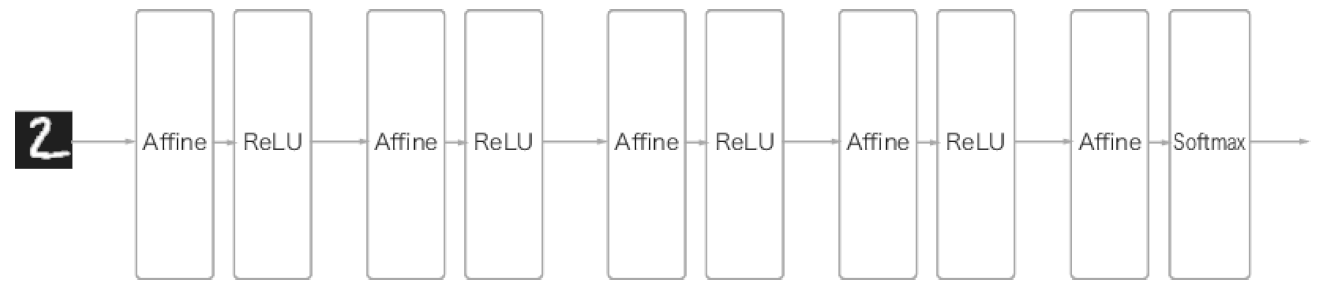

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-1.png")

[그림7-1]과 같이 완전연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층(혹은 Sigmoid 계층)이 이어진다. 이 그림에서는 Affine-ReLU 조합이 4개가 쌓였고, 마지막 5번째 층은 Affine 계층에 이어 소프트맥스 계층에서 최종 결과(확률)를 출력한다.     

그럼 CNN의 구조는 어떻게 다를까? [그림7-2]가 CNN의 예시이다.        

#### [그림7-2] CNN으로 이뤄진 네트워크의 예 : 합성곱 계층과 풀링 계층이 새로 추가 (회색)

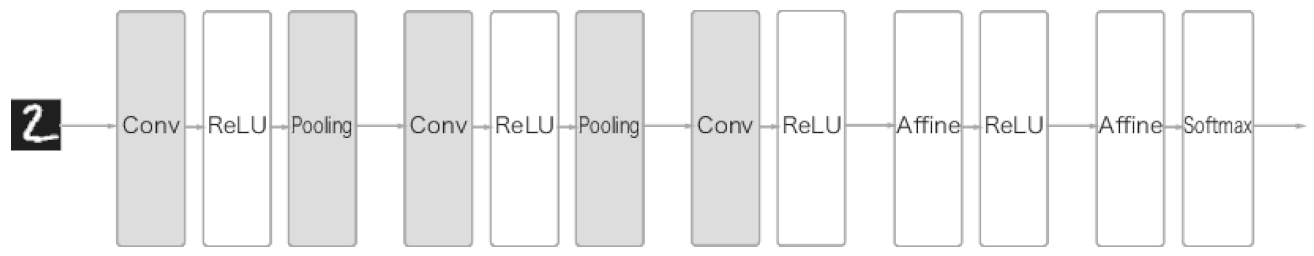

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-2.png")

[그림7-2]와 같이 CNN에서는 새로운 '$\small \text{합성곱 계층}^{\text{Conv}}$'과 '$\small \text{풀링 계층}^{\text{Pooling}}$'이 추가된다. CNN의 계층은 'Conv-ReLU-(Pooling)'흐름으로 연결된다(풀링 계층은 생략하기도 한다). 지금까지의 'Affine-ReLU'연결이 'Conv-ReLU-(Pooling)'으로 바뀌었다고 생각할 수 있는 것이다.       

[그림7-2]의 CNN에서 주목할 또 다른 점은 출력에 가까운 층에서는 지금까지의 'Affine-ReLU'구성을 사용할 수 있다는 것이다. 또, 마지막 출력 계층에서는 'Affine-Softmax'조합을 그대로 사용한다. 이상까지가 일반적인 CNN에서 흔히 볼 수 있는 구성이다.

## 7.2 합성곱 계층
CNN에서는 $\small \textbf{패딩}^{\text{padding}}$, $\small \textbf{스트라이드}^{\text{stride}}$등 CNN 고유의 용어가 등장한다. 또, 각 계층 사이에는 3차원 데이터같이 입체적인 데이터가 흐른다는 점에서 완전연결 신경망과 다르다고 할 수 있다. 그래서 CNN을 처음 배울 때는 어렵게 느껴질 수도 있으나 이 책이 있으니 걱정말자. 우선 이번 절에서는 CNN에서 사용하는 합성곱 계층의 구조를 차분히 살펴보기로 하자.

### 7.2.1 완전연결 계층의 문제점
지금까지 본 완전연결 신경망에서는 완전연결 계층(Affine 계층)을 사용하였다. 완전연결 계층에서는 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있다.        

완전연결 계층의 문제점은 무엇일까? 바로 '데이터의 형상이 무시'된다는 점이다. 입력 데이터가 이미지인 경우를 예로 들면, 이미지는 통상 세로 $\cdot$ 가로 $\cdot$ 채널 (색상)로 구성된 3차원 데이터이다. 그러나 완전연결 계층에 입력할 때는 3차원 데이터를 평평한 1차원 데이터로 평탄화해줘야 한다. 사실 지금까지의 MNIST 데이터셋을 사용한 사례에서는 형상이 (1, 28, 28)인 이미지 (1채널, 세로 28픽셀, 가로 28픽셀)를 1줄로 세운 784개의 데이터를 첫 Affine 계층에 입력하였다.     

이미지는 3차원 형상이며, 이 형상에는 소중한 공간적 정보가 담겨 있다. 예를 들어 공간적으로 가까운 픽셀은 값이 비슷하거나, RGB의 각 채널은 서로 밀접하게 관련되어 있거나, 거리가 먼 픽셀끼리는 별 연관이 없는 등, 3차원 속에서 의미를 갖는 본질적인 패턴이 숨어 있을 것이다. 그러나 완전연결 계층은 형상을 무시하고 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없다.        

한편, 합성곱 계층은 형상을 유지한다. 이미지도 3차원 데이터로 입력받으며, 마찬가지로 다음 계층에도 3차원 데이터로 전달한다. 그래서 CNN에서는 이미지처럼 형상을 가진 데이터를 제대로 이해할(가능성이 있는) 것이다.        

CNN에서는 합성곱 계층의 입출력 데이터를 $\small \text{특징 맵}^{\text{feature map}}$이라고도 한다. 합성곱 계층의 입력 데이터를 $\small \text{입력 특징 맵}^{\text{input feature map}}$, 출력 데이터를 $\small \text{출력 특징 맵}^{\text{output feature map}}$(혹은 $\small \text{활성화 맵}^{\text{activation map}}$)이라고 하는 식이다. 이 책에서는 '입출력 데이터'와 '특징 맵'을 같은 의미로 사용한다. 

### 7.2.2 합성곱 연산
합성곱 계층에서는 $\small \textbf{합성곱 연산}$을 처리한다. 합성곱 연산은 이미지 처리에서 말하는 $\small \textbf{필터 연산}$에 해당한다. 구체적인 예를 보면서 이해해보자.

#### [그림7-3] 합성곱 연산의 예

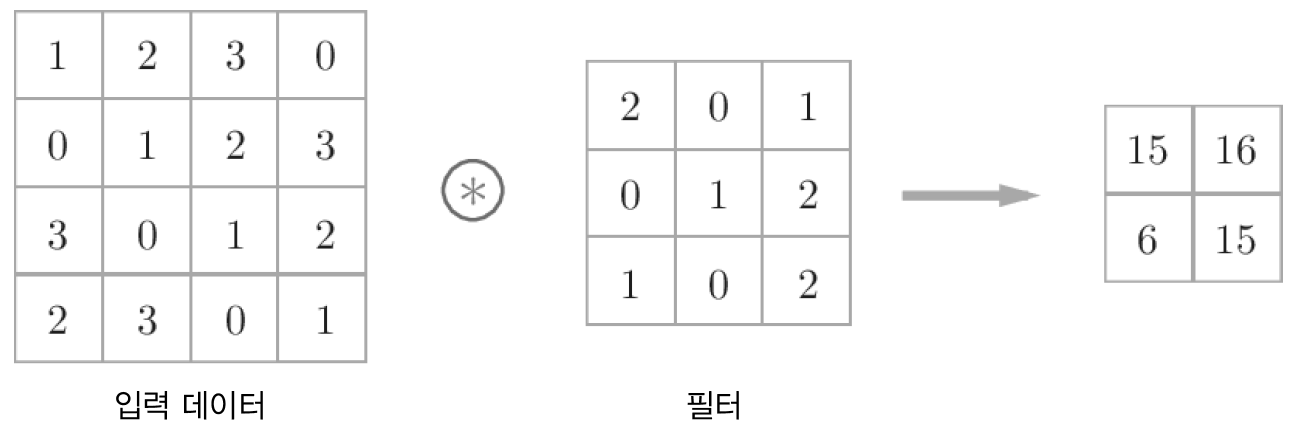

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-3.png")

[그림7-3]과 같이 합성곱 연산은 입력 데이터에 필터를 적용한다. 이 예에서 입력 데이터는 세로 $\cdot$ 가로 방향의 형상을 가졌고, 필터 역시 세로 $\cdot$ 가로 방향의 차원을 갖는다. 데이터와 필터의 형상을 $(\small \text{높이}^{\text{height}}, \text{너비}^{\text{width}})$로 표기하며, 이 예에서는 입력은 (4,4), 필터는 (3,3), 출력은 (2,2)가 된다. 문헌에 따라 필터를 $\small \textbf{커널}$이라 칭하기도 한다.

합성곱 연산은 필터의 $\small \textbf{윈도우}^{\text{window}}$를 일정 간격으로 이동해가며 입력 데이터에 적용한다. 여기에서 말하는 윈도우는 [그림7-4]의 회색 $3 \times 3$부분을 가리킨다. 이 그림에서 보듯 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구하게 된다(이 계산을 $\small \text{단일 곱셈-누산}^{\text{fused multiply-add, FMA}}$). 그리고 그 결과를 출력의 해당 장소에 저장한다. 이 과정을 모든 장소에서 수행하면 합성곱 연산의 출력이 완성된다.

#### [그림7-4] 합성곱 연산의 계산 순서

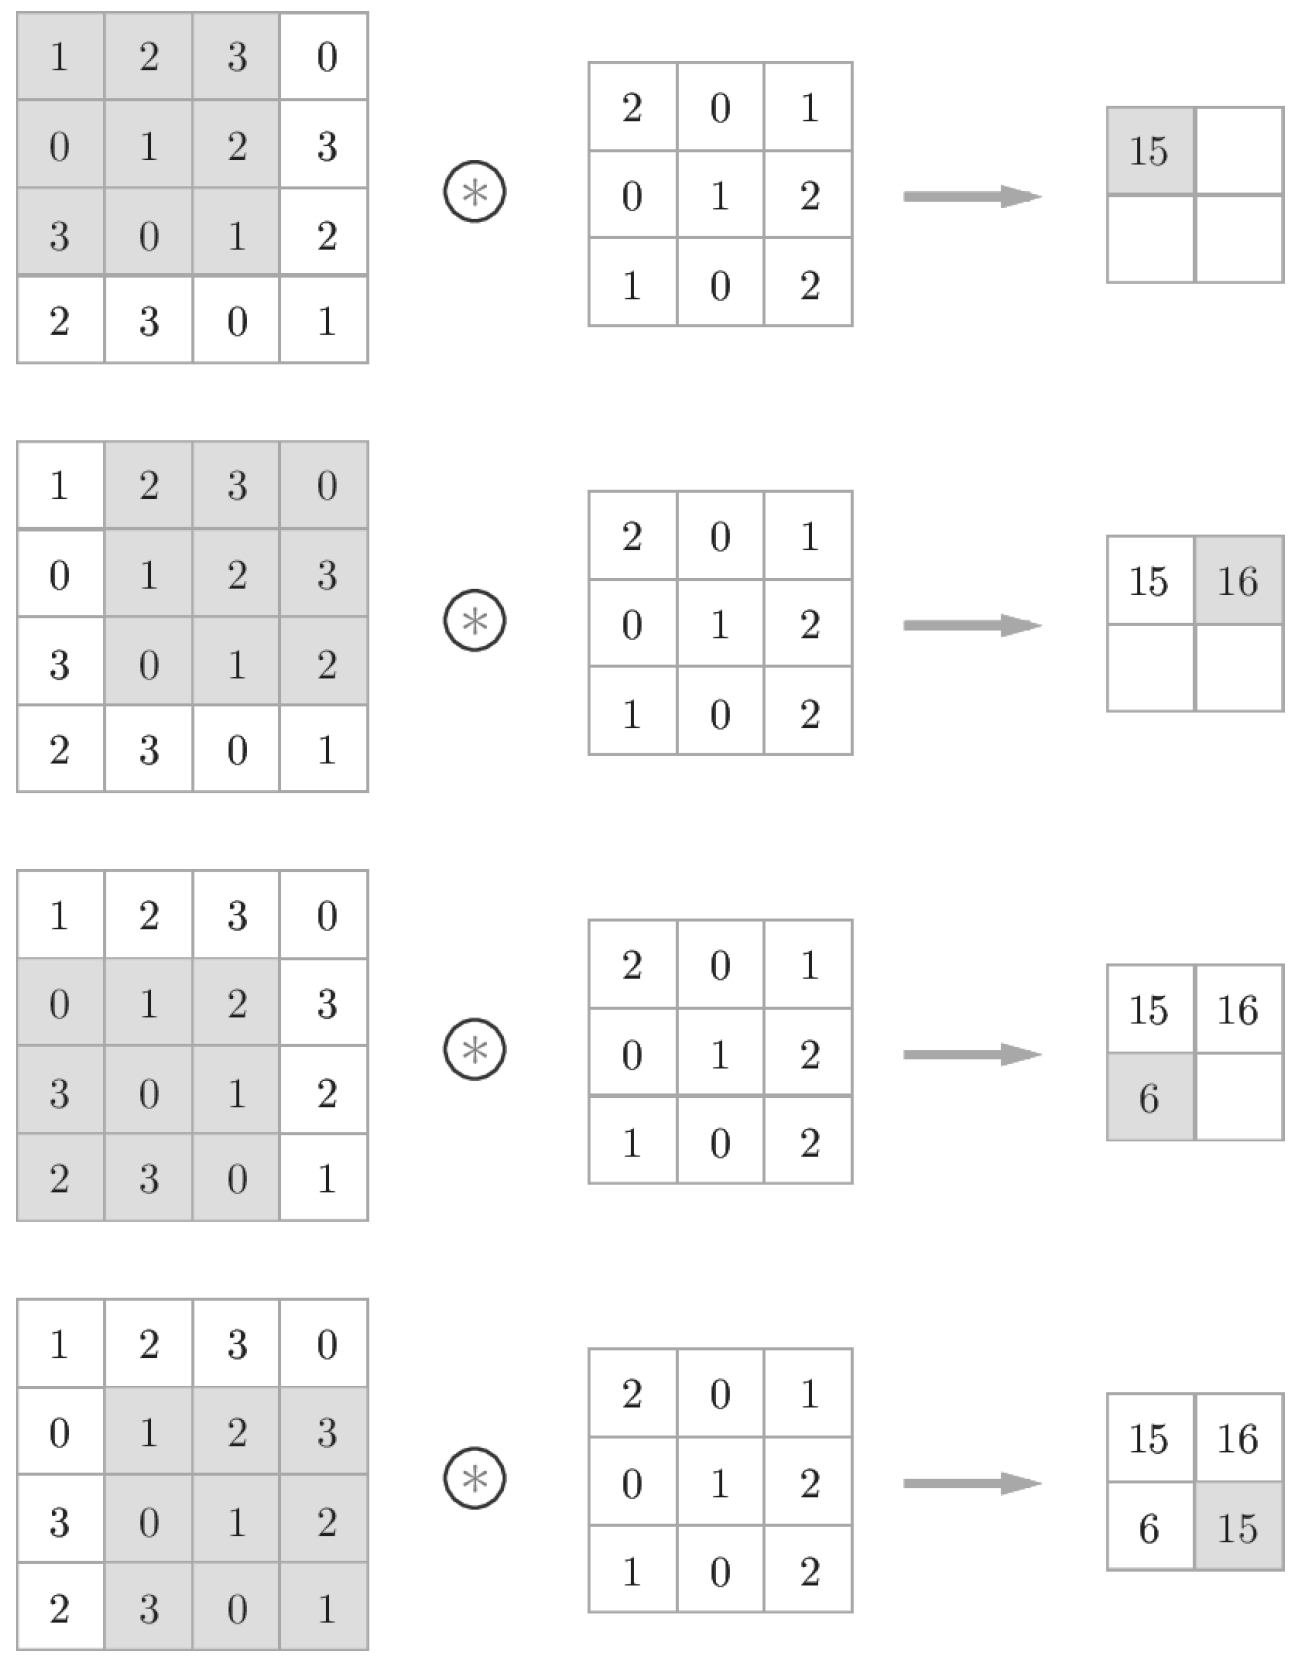

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-4.png")

자, 완전연결 신경망에는 가중치 매개변수와 편향이 존재하는데, CNN에서는 필터의 매개변수가 그동안의 '가중치'에 해당한다. 그리고 CNN에도 편향이 존재한다. [그림7-3]은 필터를 적용하는 단계까지만 보여주는 것이며, 편향까지 포함하면 [그림7-5]와 같은 흐름이 된다.

#### [그림7-5] 합성곱 연산의 편향 : 필터를 적용한 원소에 고정값(편향)을 더한다.

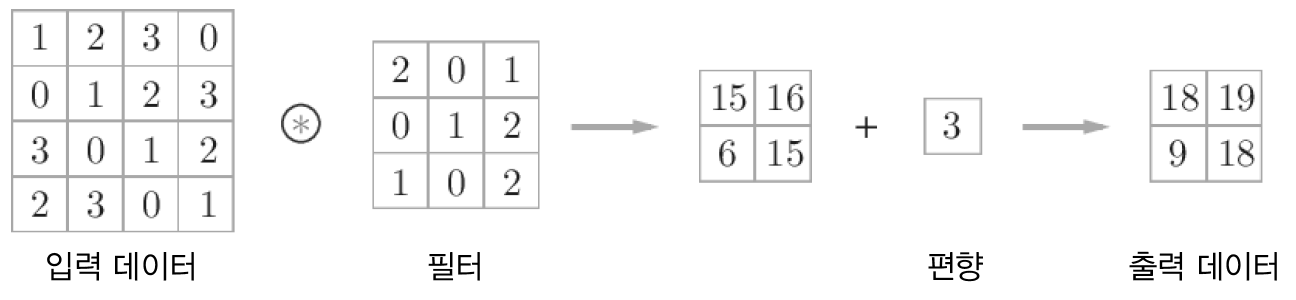

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-5.png")

[그림7-5]와 같이 편향은 필터를 적용한 후의 데이터에 더해지게 된다. 그리고 편향은 항상 하나$(1 \times 1)$만 존재한다. 그 하나의 값을 필터를 적용한 모든 원소에 더하는 것이다.

### 7.2.3 패딩
합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값(예컨대 0)으로 채우기도 한다. 이를 $\small \textbf{패딩}^{\text{padding}}$이라 하며, 합성곱 연산에서 자주 이용하는 기법이다. 예를 들어 [그림7-6]은 $(4,4)$크기의 입력 데이터에 폭이 1인 패딩을 적용한 모습이다. 폭 1짜리 패딩이라 하면 입력 데이터 사방 1픽셀을 특정 값으로 채우는 것을 의미한다.     

#### [그림7-6] 합성곱 연산의 패딩 처리 : 입력 데이터 주위에 0을 채운다(패딩은 점선으로 표기했으며 그 안의 값 '0'은 생략하였다).

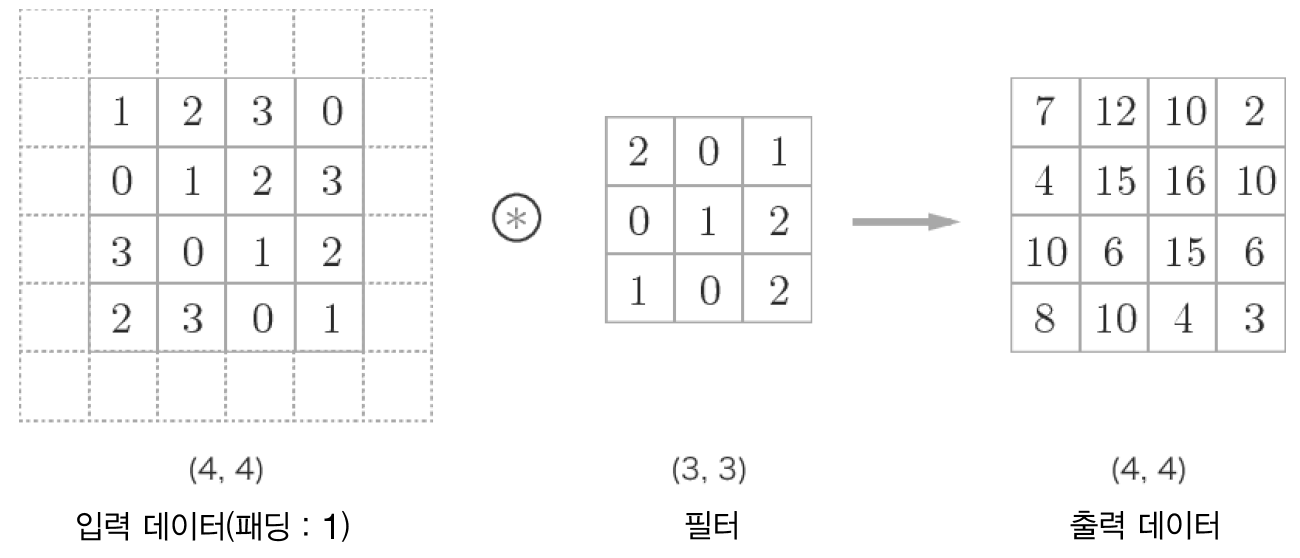

In [5]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-6.png")

[그림7-6]과 같이 처음에 크기가 (4,4)인 입력 데이터에 패딩이 추가되어 (6,6)이 된다. 이 입력에 (3,3)크기의 필터를 걸면 (4,4)크기의 출력 데이터가 생성된다. 이 예에서는 패딩을 1로 설정했지만, 2나 3 등 원하는 정수로 설정할 수 있다. 만약 [그림7-5]에 패딩을 2로 설정하면 입력 데이터의 크기는 (8,8)이 되고 3으로 설정하면 (10,10)이 된다.

$\textbf{NOTE}$     
> 패딩은 주로 출력 크기를 조정할 목적으로 사용한다. 예를 들어 (4,4) 입력 데이터에 (3,3) 필터를 적용하면 출력은 (2,2)가 되어, 입력보다 2만큼 줄어들게 된다. 이는 합성곱 연산을 여러번 되풀이하는 심층 신경망에서 문제가 될 수 있는 점이다. 합성곱 연산을 거칠 때마다 크기가 작아지면 어느 시점에서는 출력 크기가 1이 되버릴 것이다. 더 이상은 합성곱 연산을 적용할 수 없다는 뜻이다. 이러한 사태를 막기 위해 패딩을 사용한다. 앞의 예에서는 패딩의 폭을 1로 설정하니 (4,4) 입력에 대한 출력이 같은 크기인 (4,4)로 유지되었다. 한 마디로 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있는 것이다.

### 7.2.4 스트라이드
필터를 적용하는 위치의 간격을 $\small \textbf{스트라이드}^{\text{stride}}$라고 한다. 지금까지 본 예는 모두 스트라이드가 1이었지만, 예를 들어 스트라이드를 2로 하면 필터를 적용하는 윈도우가 두 칸씩 이동한다(그림 7-7).     

#### [그림7-7] 스트라이드가 2인 합성곱 연산

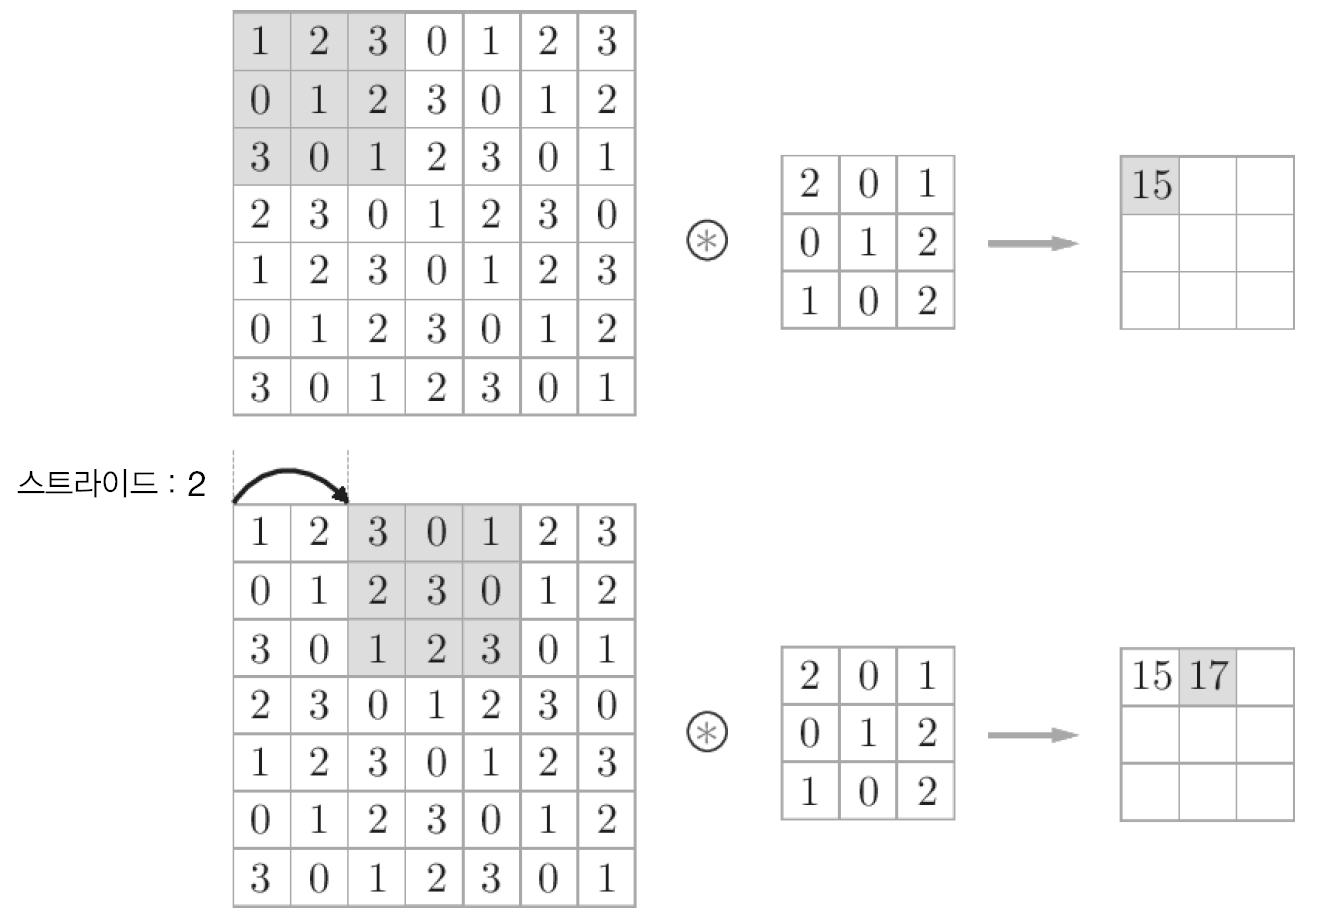

In [7]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-7.png")

[그림7-7]에서는 크기가 (7,7)인 입력 데이터에 스트라이드를 2로 설정한 필터를 적용한다. 이처럼 스트라이드는 필터를 적용하는 간격을 지정한다.      

그런데 스트라이드를 2로 하니 출력은 (3,3)이 되었다. 이처럼 스트라이드를 키우면 출력 크기는 작아진다. 한편, 패딩을 크게 하면 출력 크기가 커진다. 이러한 관계를 수식화하면 어떻게 될까? 이어서 패딩, 스트라이드가 출력 크기를 어떻게 계산하는지 살펴보자.     

입력 크기를 $(H,W)$, 필터 크기를 $(FH,FW)$, 출력 크기를 $(OH,OW)$, 패딩을 $P$, 스트라이드를 $S$라 하면, 출력 크기는 다음 식으로 계산된다.       

\begin{equation*}
    OH = \cfrac{H + 2P - FH}{S} + 1
\end{equation*}

\begin{equation*}
    OW = \cfrac{W + 2P - FW}{S} + 1
\end{equation*} \tag{7.1}

그러면 이 식을 사용하여 연습을 좀 해보자.

$\textbf{예 1 : [그림7-6]의 예}$        
입력 : (4,4), 패딩 : 1, 스트라이드 : 1, 필터 : (3,3)
\begin{equation*}
    OH = \cfrac{4 + 2 * 1 - 3}{1} + 1 = 4
\end{equation*}

\begin{equation*}
    OW = \cfrac{4 + 2 * 1 - 3}{1} + 1 = 4
\end{equation*}

$\textbf{예 2 : [그림7-7]의 예}$        
입력 : (7,7), 패딩 : 0, 스트라이드 : 2, 필터 : (3,3)
\begin{equation*}
    OH = \cfrac{7 + 2 * 0 - 3}{2} + 1 = 3
\end{equation*}

\begin{equation*}
    OW = \cfrac{7 + 2 * 0 - 3}{2} + 1 = 3
\end{equation*}

$\textbf{예 3}$     
입력 : (28,31), 패딩 : 2, 스트라이드 : 3, 필터 : (5,5)
\begin{equation*}
    OH = \cfrac{28 + 2 * 2 - 5}{3} + 1 = 10
\end{equation*}

\begin{equation*}
    OW = \cfrac{31 + 2 * 2 - 5}{3} + 1 = 11
\end{equation*}

이상의 예에서처럼 식 (7.1)에 단순히 값을 대입하기만 하면 출력 크기를 구할 수 있다. 단, 식 (7.1)의 $\small \cfrac{W + 2P -FW}{S}$와 $\small \cfrac{H + 2P -FH}{S}$가 정수로 나눠떨어지는 값이어야 한다는 점에 주의하자. 출력 크기가 정수가 아니면 오류를 내는 등의 대응을 해줘야 한다. 덧붙이자면, 딥러닝 프레임워크 중에는 값이 딱 나눠떨어지지 않을 때는 가장 가까운 정수로 반올림하는 등, 특별히 에러를 내지 않고 진행하도록 구현하는 경우도 있다.

### 7.2.5 3차원 데이터의 합성곱 연산
지금까지 2차원 형상을 다루는 합성곱 연산을 살펴보았다. 그러나 이미지만 해도 세로 $\cdot$ 가로에 더해서 채널까지 고려한 3차원 데이터이다. 이번 절에서는 조금 전과 같은 순서로, 채널까지 고려한 3차원 데이터를 다루는 합성곱 연산을 살펴보도록 하자.      

[그림7-8]은 3차원 데이터의 합성곱 연산 예이다. 그리고 [그림7-9]는 계산 순서이다. 2차원일 때(그림 7-3)와 비교하면, 길이 방향(채널 방향)으로 특징 맵이 늘어났다. 채널쪽으로 특징 맵이 여러 개 있다면 입력 데이터와 필터의 합성곱 연산을 채널마다 수행하고, 그 결과를 더해서 하나의 출력을 얻는다.     

#### [그림7-8] 3차원 데이터 합성곱 연산의 예

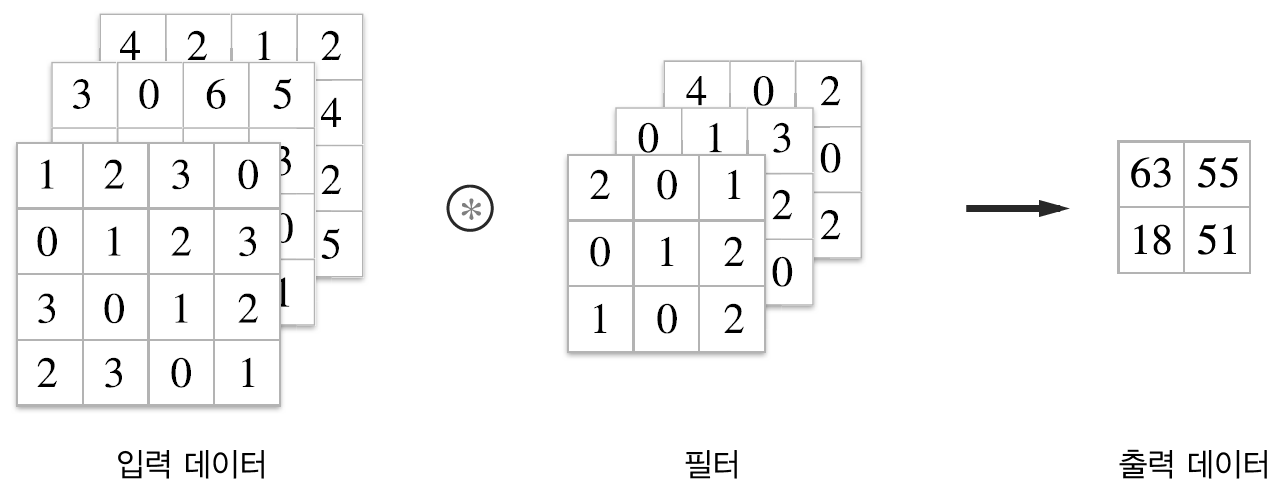

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-8.png")

#### [그림7-9] 3차원 데이터 합성곱 연산의 계산 순서

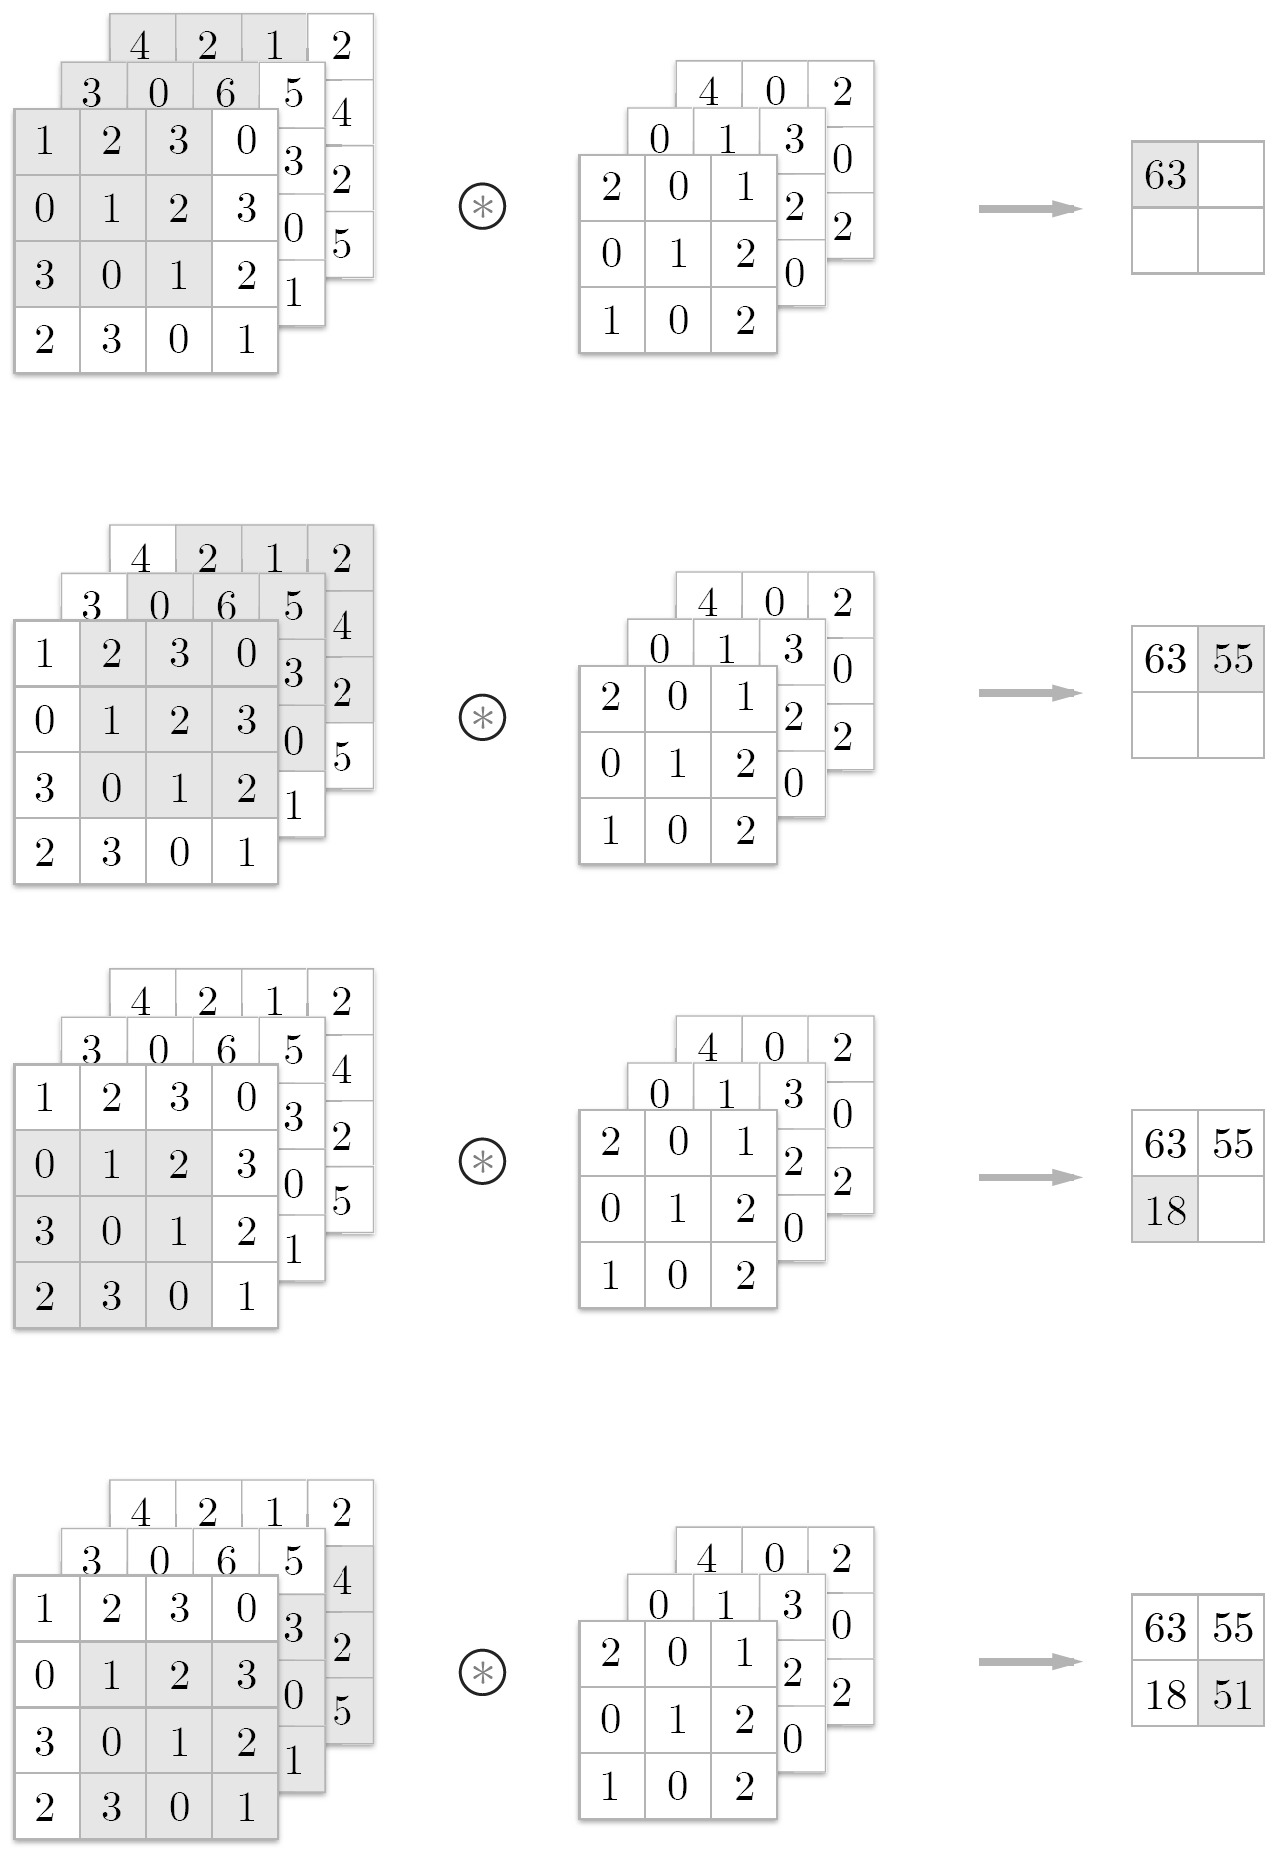

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-9.png")

3차원의 합성곱 연산에서 주의할 점은 입력 데이터의 채널 수와 필터의 채널 수가 같아야 한다는 것이다. 이 예에서는 모두 3개로 일치한다. 한편, 필터 자체의 크기는 원하는 값으로 설정할 수 있다(단, 모든 채널의 필터가 같은 크기여야 한다). 이 예에서는 필터의 크기가 (3,3)이지만, 원한다면 (2,2)나 (1,1) 또는 (5,5) 등으로 설정해도 되는 것이다. 다시 말하지만, 필터의 채널 수는 입력 데이터의 채널 수와 같도록(이 예에서는 3) 설정해야 한다.

### 7.2.6 블록으로 생각하기
3차원의 합성곱 연산은 데이터와 필터를 직육면체 블록이라고 생각하면 쉽다. 블록은 [그림7-10]과 같은 3차원 직육면체이다. 또, 3차원 데이터를 다차원 배열로 나타낼 때는 $(\small \text{채널}^{\text{channel}}, \text{높이}^{\text{height}}, \text{너비}^{\text{width}})$순서로 쓰도록 한다. 예를 들면 채널 수 $C$, 높이 $H$, 너비 $W$인 데이터의 형상은 $(C,H,W)$로 쓴다. 필터도 같은 순서로 쓴다. 예를 들어 채널 수 $C$, 필터 높이 $\small \text{FH}^{\text{Filter Height}}$, 필터 너비 $\small \text{FW}^{\text{Filter Width}}$의 경우 $(C, FH, FW)$로 쓴다.

#### [그림7-10] 합성곱 연산을 직육면체 블록으로 생각한다. 블록의 형상에 주의하도록 하자.

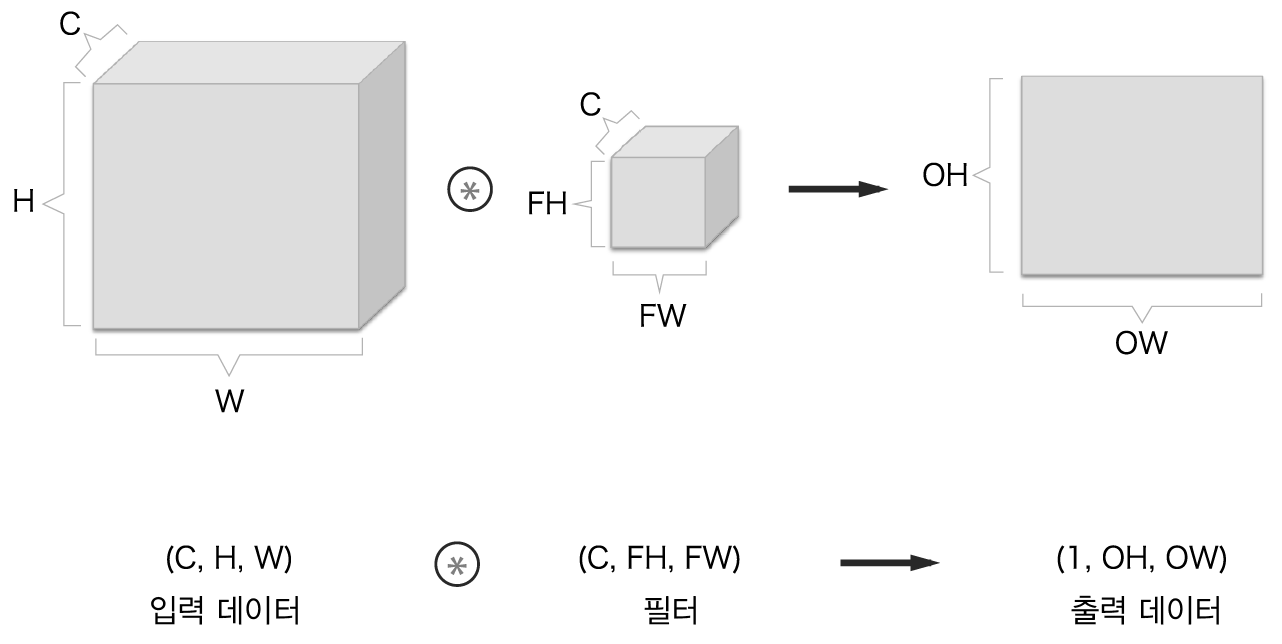

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-10.png")

자, 이 예에서 출력 데이터는 한 장의 특징 맵이다. 한 장의 특징 맵은 다른 말로 하면 채널이 1개인 특징 맵이다. 그럼 합성곱 연산의 출력으로 다수의 출력을 내보내려면 어떻게 해야 할까? 그 답은 필터(가중치)를 다수 사용하는 것이다. 그림으로는 [그림7-11]처럼 된다.

#### [그림7-11] 여러 필터를 사용한 합성곱 연산의 예

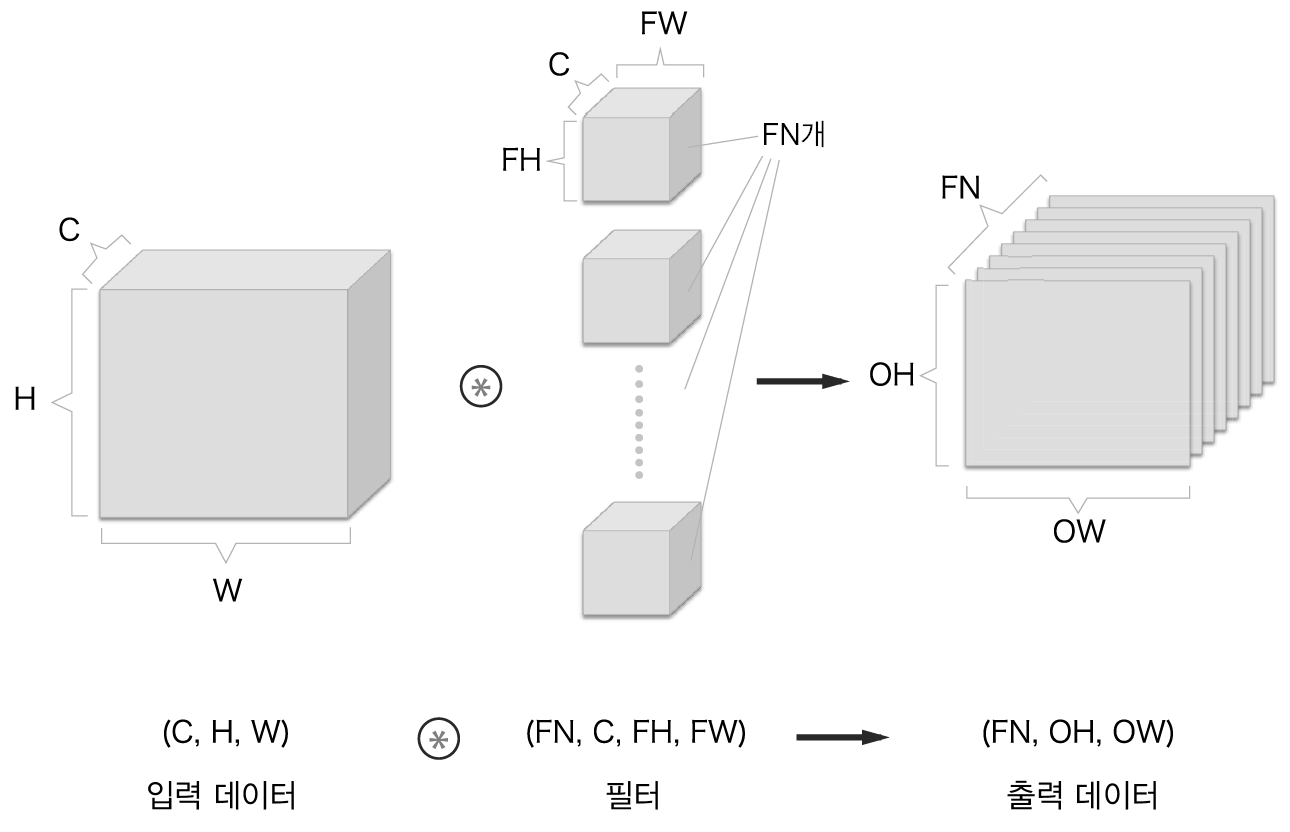

In [5]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-11.png")

이 그림과 같이 필터를 $FN$개 적용하면 출력 맵도 $FN$개 생성된다. 그리고 그 $FN$개의 맵을 모으면 형상이 $(FN, OH, OW)$인 블록이 완성된다. 이 완성된 블록을 다음 계층으로 넘기겠다는 것이 CNN의 처리 흐름이다.        

이상에서 보듯 합성곱 연산에서는 필터의 수도 고려해야 한다. 그런 이유로 필터의 가중치 데이터는 4차원 데이터이며 (출력 채널 수, 입력 채널 수, 높이, 너비) 순으로 쓴다. 예를 들어 채널 수 3, 크기 $5 \times 5$인 필터가 20개 있다면 (20,3,5,5)로 쓰게 된다.        

자, 합성곱 연산에도 (완전연결 계층과 마찬가지로) 편향이 쓰인다. [그림7-12]는 [그림7-11]에 편향을 더한 모습이다.

#### [그림7-12] 합성곱 연산의 처리 흐름(편향 추가)

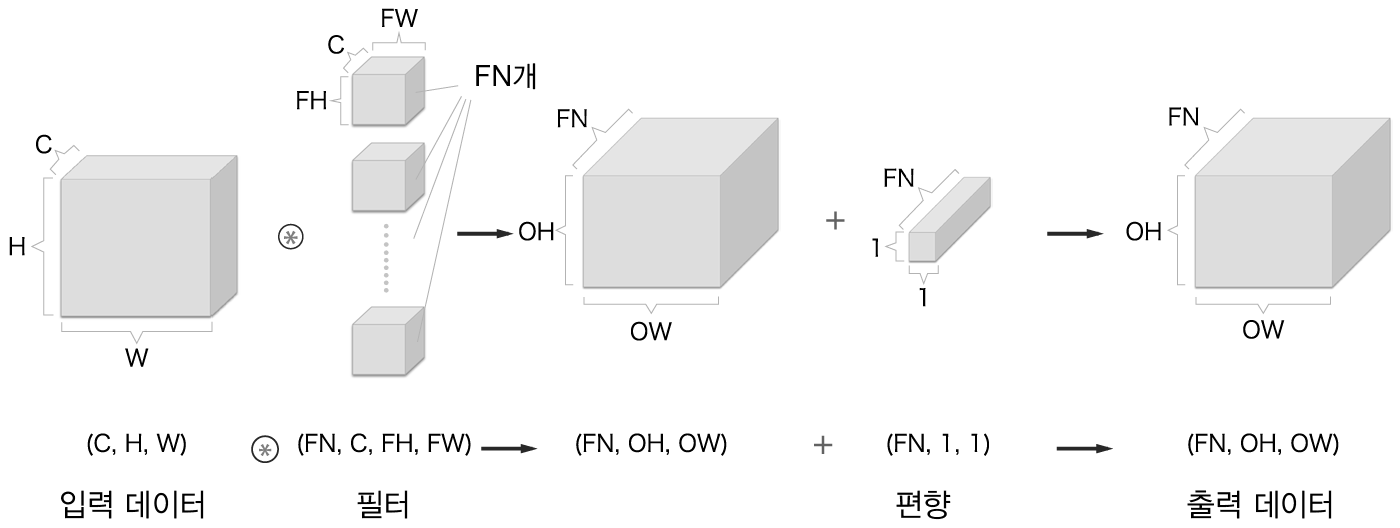

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-12.png")

[그림7-12]에서 보듯 편향은 채널 하나에 값 하나씩으로 구성된다. 이 예에서는 편향의 형상은 $(FN,1,1)$이고, 필터의 출력 결과의 형상은 $(FN, OH, OW)$이다. 이 두 블록을 더하면 편향의 각 값이 필터의 출력인 $(FN, OH, OW)$ 블록의 대응 채널의 원소 모두에 더해진다. 참고로, 형상이 다른 블록의 덧셈은 넘파이의 브로드캐스트 기능으로 쉽게 구현가능하다.

### 7.2.7 배치 처리
신경망 처리에서는 입력 데이터를 한 덩어리로 묶어 배치로 처리하였다. 완전연결 신경망을 구현하면서는 이 방식을 지원하여 처리 효율을 높이고, 미니배치 방식의 학습도 지원하도록 하였다.     

합성곱 연산도 마찬가지로 배치 처리를 지원하고자 한다. 그래서 각 계층을 흐르는 데이터의 차원을 하나 늘려 4차원 데이터로 저장한다. 구체적으로는 데이터를 (데이터 수, 채널 수, 높이, 너비) 순으로 저장한다. 데이터가 $N$개일 때 [그림7-12]를 배치 처리한다면 데이터 형태가 [그림7-13]처럼 되는 것이다.     

#### [그림7-13] 합성곱 연산의 처리 흐름(배치 처리)


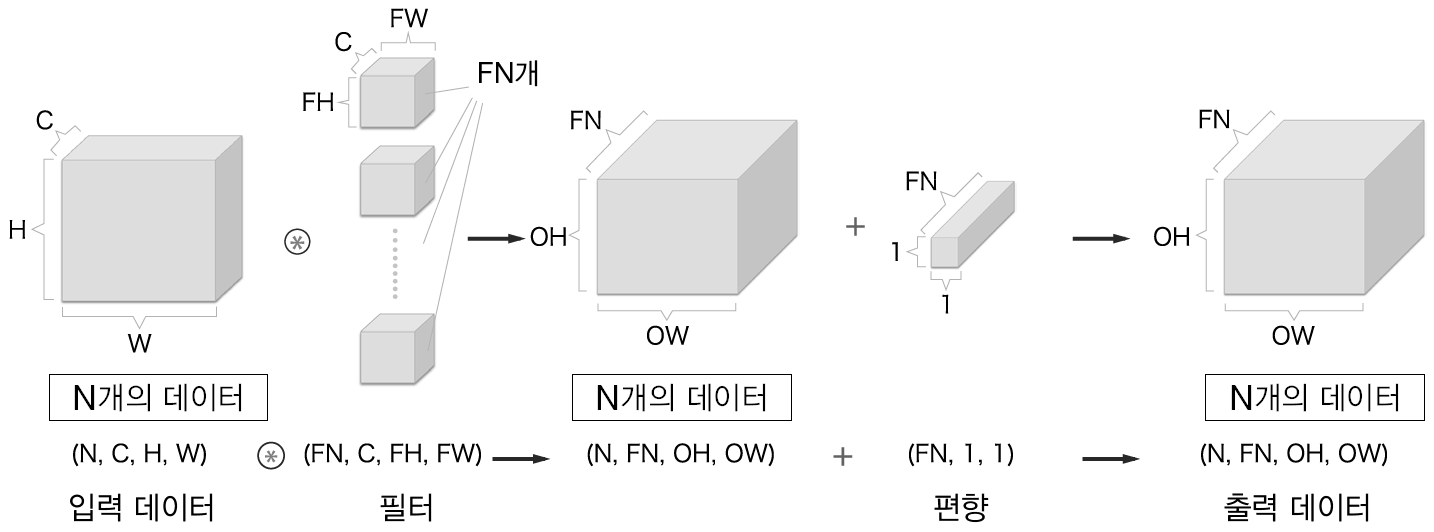

In [7]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-13.png")

배치 처리 시의 데이터 흐름을 나타낸 [그림7-13]을 보면 각 데이터의 선두에 배치용 차원을 추가하였다. 이처럼 데이터는 4차원 형상을 가진 채 각 계층을 타고 흐른다. 여기에서 주의할 점으로는 신경망에 4차원 데이터가 하나 흐를 때마다 데이터 $N$개에 대한 합성곱 연산이 이뤄진다는 것이다. 즉 $N$회 분의 처리를 한 번에 수행하는 것이다.

## 7.3 풀링 계층
풀링은 세로 $\cdot$ 가로 방향의 공간을 줄이는 연산이다. 예를 들어 [그림7-14]와 같이 풀링은 $2 \times 2$영역을 원소 하나로 집약하여 공간 크기를 줄일 수 있다.

#### [그림7-14] 최대 풀링의 처리 순서

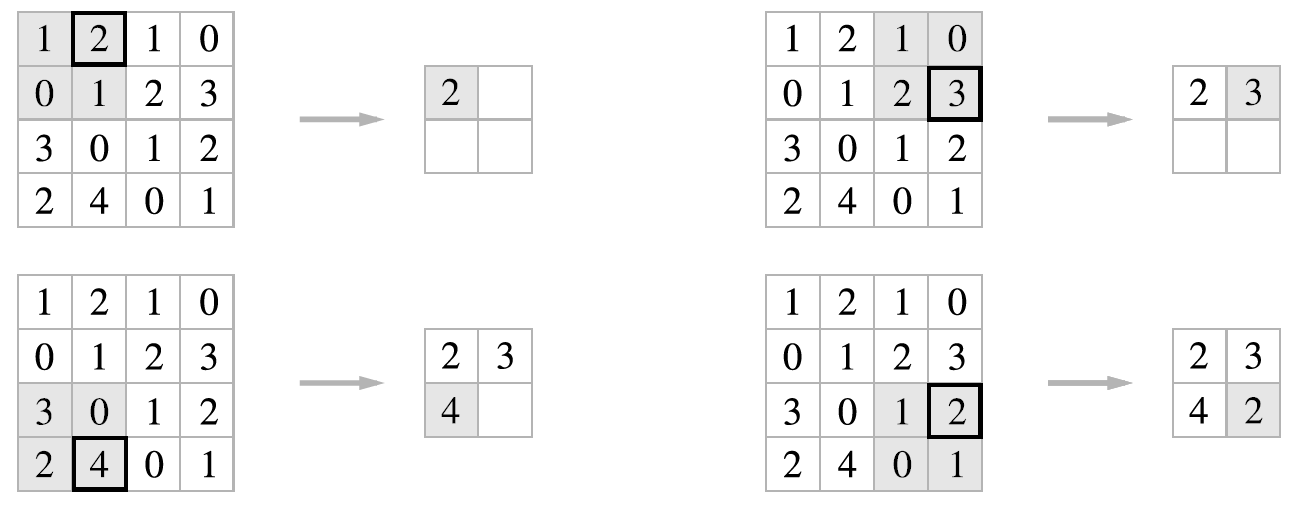

In [8]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-14.png")

[그림7-14]는 $2 \times 2 \small \textbf{최대 풀링}^{\text{max pooling, 맥스 풀링}}$을 스트라이드 2로 처리하는 순서이다. 최대 풀링은 $\small \text{최댓값}^{\text{max}}$을 구하는 연산으로, '$2 \times 2$'는 대상 영역의 크기를 뜻한다. 즉 $2 \times 2$ 최대 풀링은 그림과 같이 $2 \times 2$ 크기의 영역에서 가장 큰 원소 하나를 꺼낸다. 또, 스트라이드는 이 예에서는 2로 설정했으므로 $2 \times 2$ 윈도우가 원소 2칸 간격으로 이동한다. 참고로, 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정하는 것이 보통이다. 예를 들어 윈도우가 $3 \times 3$이면 스트라이드는 3으로, 윈도우가 $4 \times 4$이면 스트라이드를 4로 설정한다.

$\textbf{WARNING}$      
> 풀링은 최대 풀링외에도 $\small \textbf{평균 풀링}^{\text{average pooling}}$등이 있다. 최대 풀링은 대상 영역에서 최댓값을 취하는 연산인 반면, 평균 풀링은 대상 영역의 평균을 계산한다. 이미지 인식 분야에서는 주로 최대 풀링을 사용한다. 그래서 이 책에서는 풀링 계산이라고 하면 최대 풀링을 말하는 것이다.

### 7.3.1 풀링 계층의 특징
풀링 계층의 특징은 무엇일까?        

$\textbf{학습해야 할 매개변수가 없다}$      
풀링 계층은 합성곱 계층과 달리 학습해야 할 매개변수가 없다. 풀링은 대상 영역에서 최댓값이나 평균을 취하는 명확한 처리이므로 특별히 학습할 것이 없다.        

$\textbf{채널 수가 변하지 않는다}$      
풀링 연산은 입력 데이터의 채널 수 그대로 출력 데이터로 내보낸다. [그림7-15]처럼 채널마다 독립적으로 계산하기 때문이다.              

#### [그림7-15] 풀링은 채널 수를 바꾸지 않는다.

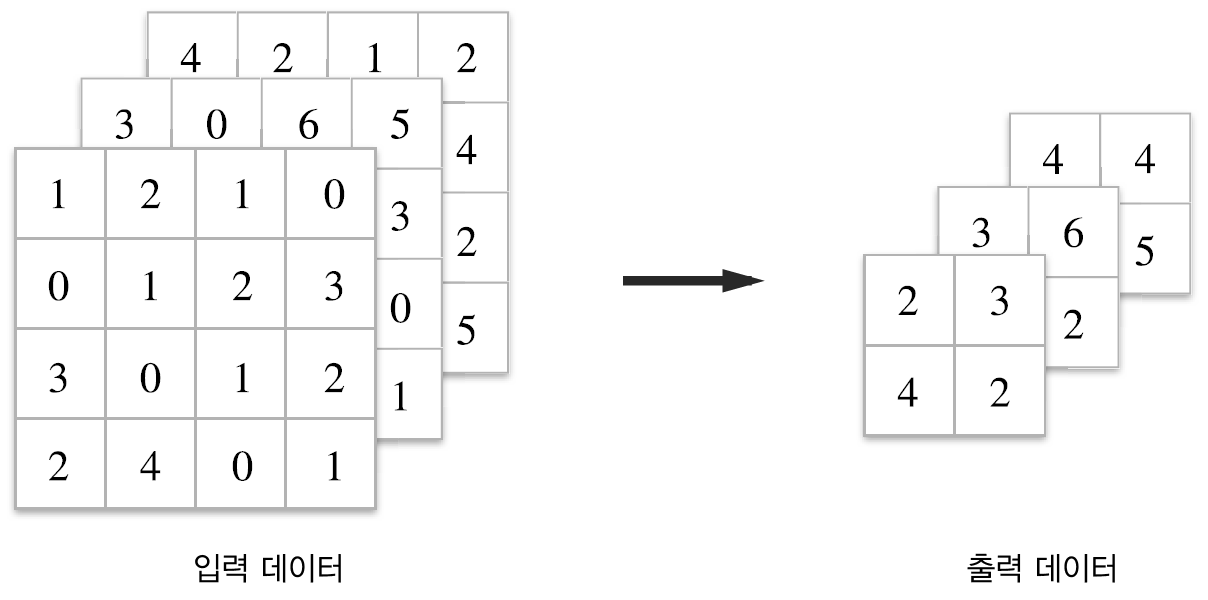

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-15.png")

$\textbf{입력의 변화에 영향을 적게 받는다(강건하다)}$      
입력 데이터가 조금 변해도 풀링의 결과는 잘 변하지 않는다. 예를 들어 [그림7-16]은 입력 데이터의 차이(데이터가 오른쪽으로 1칸씩 이동)를 풀링이 흡수해 사라지게 하는 모습을 보여준다.      

#### [그림7-16] 입력 데이터가 가로로 1원소만큼 어긋나도 출력은 같다(데이터에 따라서는 다를 수도 있다).

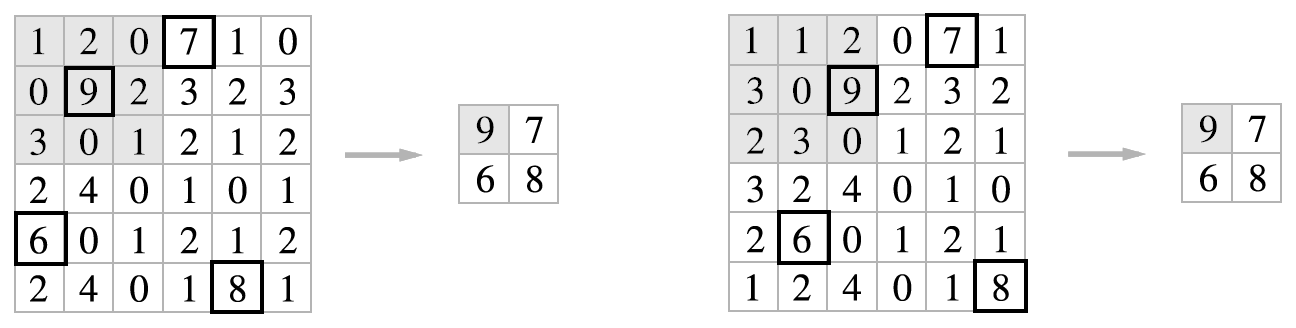

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-16.png")

## 7.4 합성곱/풀링 계층 구현하기
지금까지 합성곱 계층과 풀링 계층에 대해 자세히 설명해보았다. 이번 절에서는 이 두 계층을 파이썬으로 구현해보자. "5장 오차역전파법"에서 설명한 것처럼 이번 절에서 구현하는 클래스에도 `forward`와 `backward`메서드를 추가하여 모듈로 이용할 수 있도록 하였다.     

합성곱 계층과 풀링 계층은 복잡해 보이지만, 사실 '트릭'을 사용하면 쉽게 구현할 수 있다. 이번 절에서는 그 트릭을 활용하여 문제를 간단히 하면서 합성곱 계층을 구현해보자.

### 7.4.1 4차원 배열
앞에서 설명한 대로 CNN에서 계층 사이를 흐르는 데이터는 4차원이다. 예를 들어 데이터의 형상이 $(10,1,28,28)$이라면, 이는 높이 28, 너비 28, 채널이 1개인 데이터가 10개라는 말이다. 이를 파이썬으로 구현하면 다음과 같다.


In [5]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

여기에서 (10개 중) 첫 번째 데이터에 접근하려면 단순히 `x[0]`이라고 쓴다(파이썬의 인덱스는 0부터 시작한다). 마찬가지로 두 번째 데이터는 `x[1]`위치에 있다.

In [6]:
print(x[0].shape)
print(x[1].shape)

(1, 28, 28)
(1, 28, 28)


또, 첫 번째 데이터의 첫 채널의 공간 데이터에 접근하려면 다음과 같이 쓴다.

In [8]:
x[0, 0].shape # 또는 x[0][0].shape

(28, 28)

이처럼 CNN은 4차원 데이터를 다룬다. 그래서 합성곱 연산의 구현은 복잡해질 것 같지만, 다음 절에서 설명하는 `im2col`이라는 '트릭'이 문제를 단순하게 만들어준다.

### 7.4.2 im2col로 데이터 전개하기

합성곱 연산을 곧이곧대로 구현하려면 `for`문을 겹겹이 써야할 것이다. 생각만 해도 귀찮고, 또 넘파이에 `for`문을 사용하면 성능이 떨어진다는 단점도 있다(넘파이에서는 원소에 접근할 때 `for`문을 사용하지 않는 것이 바람직하다). 이번 절에서는 `for`문 대신 `im2col`이라는 편의 함수를 사용하여 합성곱/풀링 계층을 간단하게 구현해보자.

`im2col`은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) 함수이다. [그림7-17]과 같이 3차원 입력 데이터에 `im2col`을 적용하면 2차원 행렬로 바뀐다(정확히는 배치 안의 데이터 수까지 포함한 4차원 데이터를 2차원으로 변환한다).

#### [그림7-17] (대략적인) `im2col`의 동작

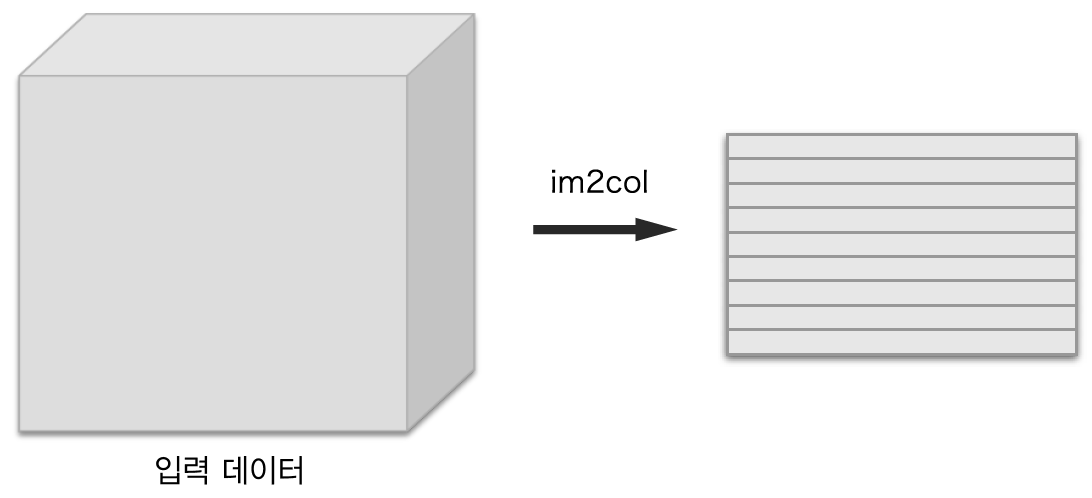

In [9]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-17.png")

`im2c0l`은 필터링하기 좋게 입력 데이터를 전개한다. 구체적으로는 [그림7-18]과 같이 입력 데이터에서 필터를 적용하는 영역(3차원 블록)을 한 줄로 늘어놓는다. 이 전개를 필터를 적용하는 모든 영역에서 수행하는 게 `im2col`이다.      

#### [그림7-18] 필터 적용 영역을 앞에서부터 순서대로 1줄로 펼친다.

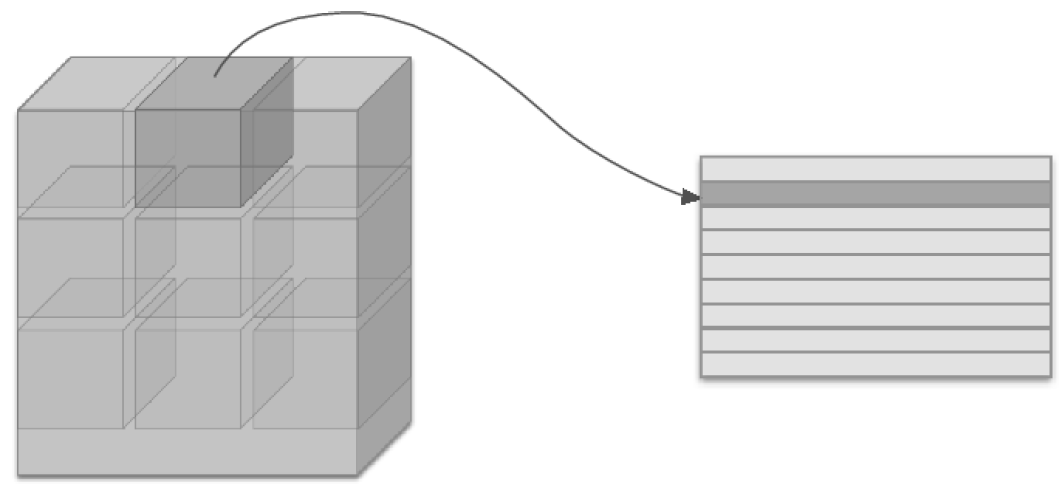

In [10]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-18.png")

[그림7-18]에서는 보기에 좋게끔 스트라이드를 크게 잡아 필터의 적용 영역이 겹치지 않도록 했지만, 실제 상황에서는 영역이 겹치는 경우가 대부분이다. 필터 적용 영역이 겹치게 되면 `im2col`로 전개한 후의 원소 수가 원래 블록의 원소 수보다 많아진다. 그래서 `im2col`을 사용하여 구현하면 메모리를 더 많이 소비하게 되는 단점이 있다. 하지만 컴퓨터는 큰 행렬을 묶어서 계산하는데 탁월하다. 예를 들어 행렬 계산 라이브러리(선형 대수 라이브러리)등은 행렬 계산에 고도로 최적화되어 큰 행렬의 곱셈을 빠르게 계산할 수 있다.(BLAS) 그래서 문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용하여 효율을 높일 수 있다.      

$\textbf{NOTE}$     
> `im2col`은 'image to column', 즉 '이미지에서 행렬로'라는 뜻이다. $\small \text{카페}^{\text{Caffe}}$와 $\small \text{체이너}^{\text{Chainer}}$등의 딥러닝 프레임워크는 `im2col`이라는 이름의 함수를 만들어 합성곱 계층을 구현할 때 이용하고 있다.

`im2col`로 입력 데이터를 전개한 다음에는 합성곱 계층의 필터(가중치)를 1열로 전개하고, 두 행렬의 곱을 계산하면 된다(그림 7-19). 이는 완전연결 계층의 Affine 계층에서 한 것과 거의 같다.

#### [그림7-19] 합성곱 연산의 필터 처리 상세 과정
필터를 세로로 1열로 전개하고, `im2col`이 전개한 데이터와 행렬 곱을 계산한다. 마지막으로 출력 데이터를 변형(reshape)한다.

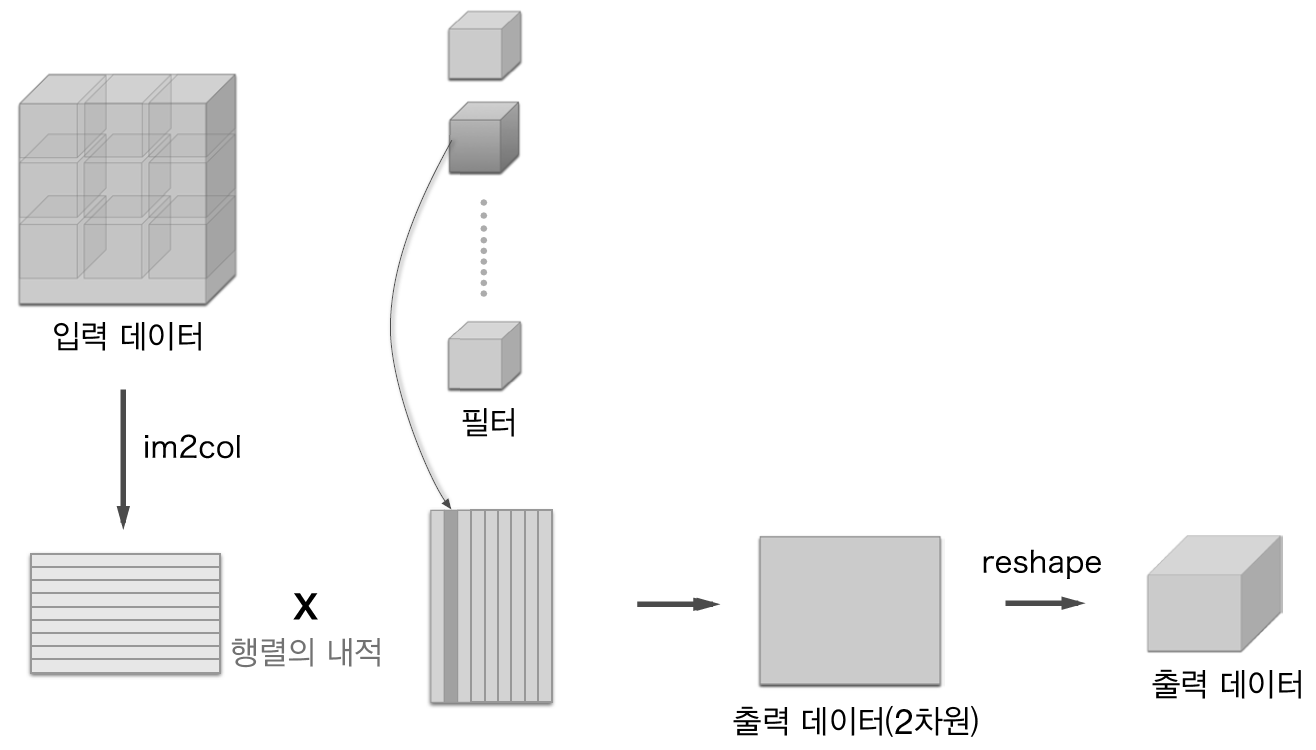

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-19.png")

[그림7-19]와 같이 `im2col`방식으로 출력한 결과는 2차원 행렬이다. CNN은 데이터를 4차원 배열로 저장하므로 2차원인 출력 데이터를 4차원으로 $\small \text{변형}^{\text{reshape}}$한다. 이상이 합성곱 계층의 구현 흐름이다.

### 7.4.3 합성곱 계층 구현하기
이 책에서는 `im2col`함수를 미리 만들어 제공한다. 사실 그 구현은 간단한 함수 10개 정도를 묶은 것이니, 궁금하다면 common/util.py를 참고하자.      

`im2col` 함수의 인터페이스는 다음과 같다.

```python
im2col(input_data, filter_h, filter_w, stride = 1, pad = 0)
```

- `input_data` : (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이뤄진 입력 데이터
- `filter_h` : 필터의 높이
- `filter_w` : 필터의 너비
- `stride` : 스트라이드
- `pad` : 패딩

이 `im2col`은 '필터 크기', '스트라이드', '패딩'을 고려하여 입력 데이터를 2차원 배열로 전개한다. 그러면 이 `im2col`을 실제로 사용해보자.

In [3]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.util import im2col

x1 = np.random.randn(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75), 75는 필터의 원소 수, 9는 출력 데이터 수 * 합성곱 연산 횟수

x2 = np.random.randn(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)


(9, 75)
(90, 75)


여기에서는 두 가지 예를 보여주고 있다. 첫 번째는 배치 크기가 1(데이터 1개), 채널은 3개, 높이 $\cdot$ 너비가 $7 \times 7$의 데이터이고, 두 번째는 배치 크기만 10이고 나머지는 첫 번째와 같다. `im2col`함수를 적용한 두 경우 모두 2번째 차원의 원소는 75개이다. 이 값은 필터의 원소 수와 같다(채널 3개, $5 \times 5$ 데이터). 또한, 배치 크기가 1일 때는 `im2col`의 결과의 크기가 (9,75)이고, 10일 때는 그 10배인 (90,75) 크기의 데이터가 저장된다.

이제 이 `im2col`을 사용하여 합성곱 계층을 구현해보자. 여기에서는 합성곱 계층을 `Convolution`이라는 클래스로 구현하였다.

In [18]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.util import im2col, col2im

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad) # col 형상 : (N * out_h * out_w, C * FH * FW)
        print(f"x im2col 변환후 형상 : {col.shape}")
        col_W = self.W.reshape(FN, -1).T # col_W 형상 : (C * FH * FW, FN)
        print(f"필터 전개 후 형상 : {col_W.shape}")
        out = np.dot(col, col_W) + self.b
        print(f"행렬 계산 후 형상 : {out.shape}")
        # out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        out = out.reshape(N, out_h, out_w, -1)
        print(f"reshape 후 형상 : {out.shape}")
        out = out.transpose(0, 3, 1, 2)
        print(f"transpose 후 형상 : {out.shape}")
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        # dout 형상 : (N, FN, out_h, out_w)
        # transpose 후 형상 : (N, out_h, out_w, FN)
        # reshape 후 형상 : (N * out_h * out_w, FN)
        dout = dout.transpose(0,2,3,1).reshape(-1, FN) # 바뀐 dout 형상 : (N * out_h * out_w, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout) # dW 형상 : (C * FH * FW, FN)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T) # dcol 형상 : (N * out_h * out_w, C * FH * FW)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad) # dx 형상 : (N, C, H, W)

        return dx

합성곱 계층은 필터(가중치), 편향, 스트라이드 패딩을 인수로 받아 초기화한다. 필터는 $(FN, C, FH, FW)$의 4차원 형상이다. 여기서 FN은 필터 개수, C는 채널, FH는 필터 높이, FW는 필터 너비이다.     

앞의 합성곱 구현 코드에서 `forward()`함수의
```python
col = im2col(x, FH, FW, self.stride, self.pad)
col_W = self.W.reshape(FN, -1).T # 필터 전개
out = np.dot(col, col_W) + self.b
```
부분을 보면, 입력 데이터를 `im2col`로 전개하고 필터도 `reshape`를 사용하여 2차원 배열로 전개하고 있다. 그리고 이렇게 전개된 두 행렬의 곱을 `np.dot(col, col_W)`으로 계산하는 과정을 거친다.     

필터를 전개하는 부분은 [그림7-19]에서 보듯 각 필터 블록을 1줄로 펼쳐 세우게 된다. 이때 `reshape`의 두번째 인수를 -1로 지정했는데, 이는 `reshape`가 제공하는 편의 기능이다. `reshape`에 -1을 지정하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절하게 묶어주게 된다. 무슨말인고 하니, 앞의 코드에서 (10,3,5,5) 형상을 한 다차원 배열 $W$의 원소 수는 750개임을 알고 있다. 이 배열에 `reshape(10,-1)`을 호출하면 750개의 원소를 10묶음으로, 즉 형상이 (10,75)인 배열로 만들어줄 수 있게된다.       

다음으로 `forward`구현의 마지막에서는 출력 데이터를 적절한 형상으로 바꿔준다. 이때 넘파이의 `transpose`함수를 사용하는데, 이는 다차원 배열의 축 순서를 바꿔주는 함수이다. [그림7-20]과 같이 인덱스(0부터 시작)를 지정하여 축의 순서를 변경해줌을 알 수 있다.

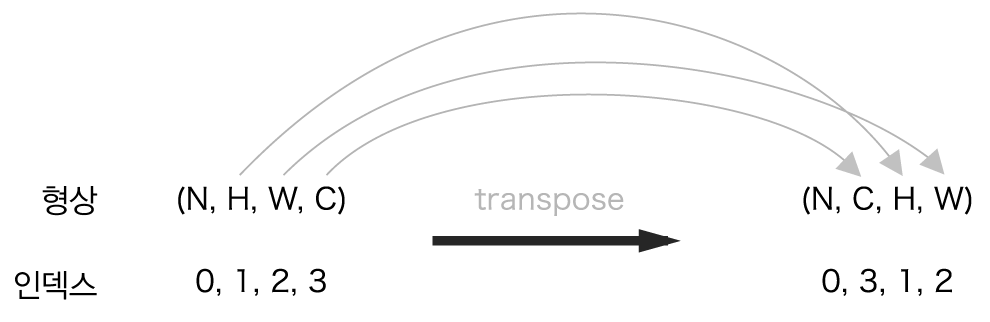

In [22]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-20.png")

이상이 합성곱 계층의 `forward`구현이다. `im2col`로 전개한 덕분에 완전연결 계층의 `Affine`계층과 거의 똑같이 구현가능함을 알 수 있다.        

합성곱 계층의 역전파에서는 `im2col`을 역으로 처리해야 한다. 이는 이 책이 제공하는 `col2im`함수를 사용하면 된다. `col2im`을 사용한다는 점을 제외하면 합성곱 계층의 역전파는 `Affine`계층과 똑같다. 합성곱 계층의 역전파 구현은 common/layer.py에 있으니 참고하자.

$\textbf{SELF NOTE}$        
> 아래의 코드 예를 살펴보면 `im2col`로 변환된 `x`의 형상이 (a,b)으로 나온다. 이때 a와 b는 각각 다음과 같다.     

\begin{equation*}
    a = N \times OH \times OW
\end{equation*}

\begin{equation*}
    b = C \times FH \times FW
\end{equation*}

> 즉, `im2col`은 합성곱 연산을 행렬 형태로 계산하기위해 x라는 데이터셋 전체에 대해 필터의 크기 FH,FW와 필터의 개수 C를 고려하여 x를 행(row)단위로 늘어뜨려놓는 함수이다. 이를 통해 BLAS를 활용한 빠른 행렬계산이 가능해지는 것이다.


In [20]:
# convolution 예시

import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.util import im2col, col2im

x = np.random.rand(10, 3, 5, 5) # 데이터 10개
W1 = np.random.rand(3, 3, 4, 4) # 필터 3개 (FN, C, FH, FW)
b1 = np.random.rand(3,)

conv1 = Convolution(W1, b1)
out1 = conv1.forward(x)

print(out1.shape) # (10, 3, 2, 2) # 데이터 수, 채널 수, 높이, 너비



x im2col 변환후 형상 : (40, 48)
필터 전개 후 형상 : (48, 3)
행렬 계산 후 형상 : (40, 3)
reshape 후 형상 : (10, 2, 2, 3)
transpose 후 형상 : (10, 3, 2, 2)
(10, 3, 2, 2)


### 7.4.4 풀링 계층 구현하기
풀링 계층 구현도 합성곱 계층과 마찬가지로 `im2col`을 사용해 입력 데이터를 전개한다. 단, 풀링의 경우엔 채널 쪽이 독립적이라는 점이 합성곱 계층 때와 다르다는 점이 있다. 구체적으로는 [그림7-21]과 같이 풀링 적용 영역을 채널마다 독립적으로 전개하게 된다.

#### [그림7-21] 입력 데이터에 풀링 적용 영역을 전개 ($2 \times 2$ 풀링의 예)

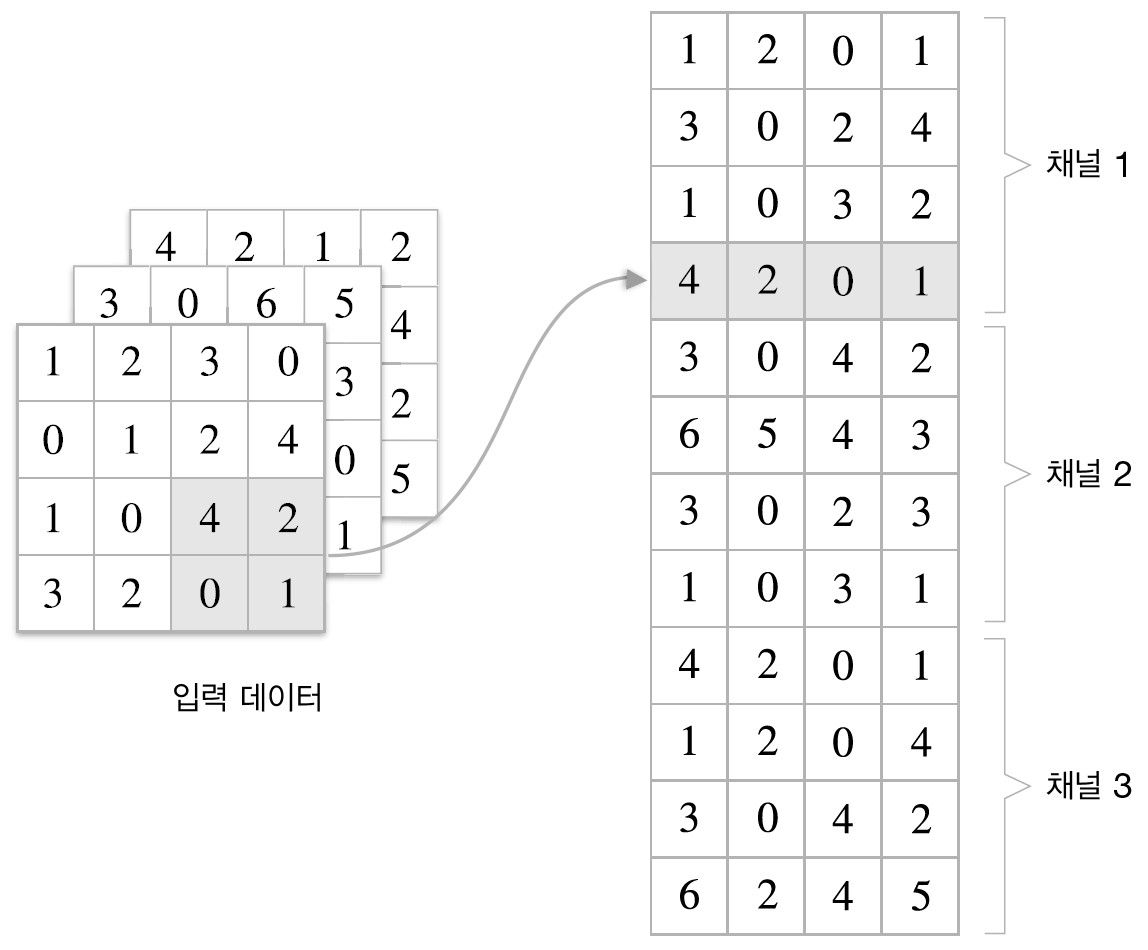

In [3]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-21.png")

일단, 이렇게 전개한 후, 전개한 행렬에서 행별 최댓값을 구하고 적절한 형상으로 성형하기만 하면 된다(그림 7-22).

#### [그림7-22] 풀링 계층 구현의 흐름 : 풀링 적용 영역에서 가장 큰 원소는 회색으로 표시

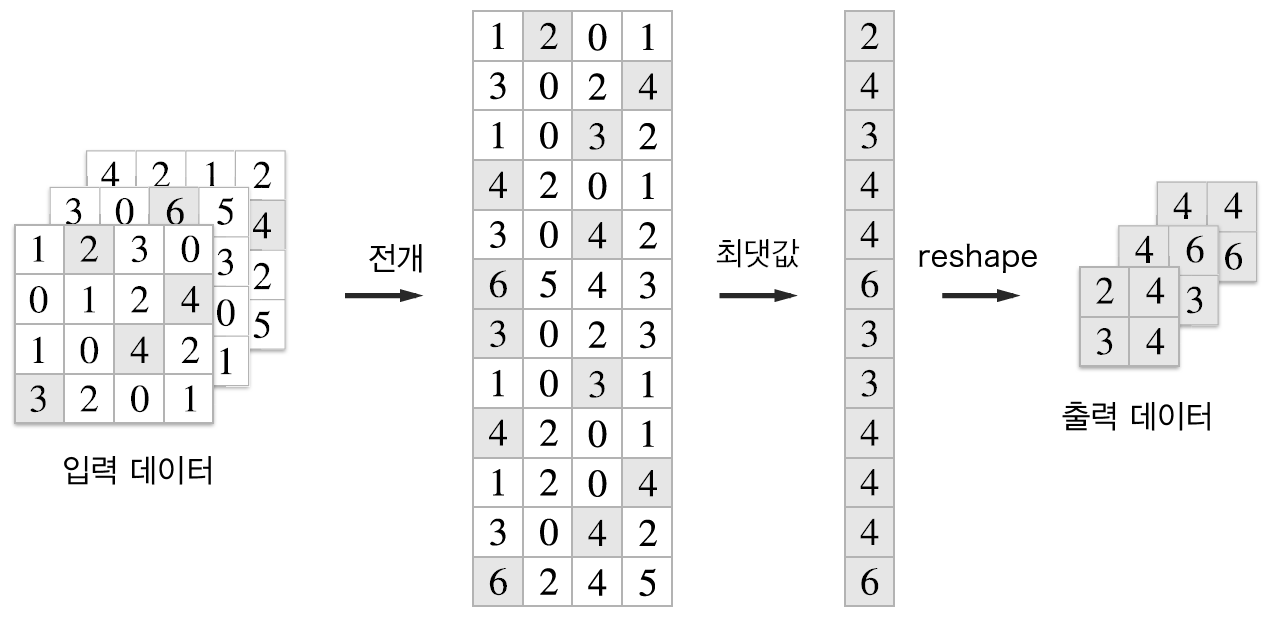

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-22.png")

이상이 풀링 계층의 `forward`처리 흐름이다. 다음은 이를 파이썬으로 구현한 코드이다.

In [8]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import *
from common.util import im2col, col2im

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad) # col 형상 : (N * out_h * out_w, C * pool_h * pool_w)
        print(f"x im2col 변환후 형상 : {col.shape}")
        col = col.reshape(-1, self.pool_h * self.pool_w) # col 형상 : (N * out_h * out_w * C, pool_h * pool_w)
        print(f"col reshape 후 형상 : {col.shape}")

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1) # out 형상 : (N * out_h * out_w * C), axis=1이므로 각 행에 대해 모든 열중에서 최댓값을 구함
        # out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        out = out.reshape(N, out_h, out_w, C) # (N, out_h, out_w, C)
        print(f"out reshape 후 형상 : {out.shape}")
        out = out.transpose(0, 3, 1, 2) # (N, C, out_h, out_w)
        print(f"out transpose 후 형상 : {out.shape}")
        
        self.x = x
        self.arg_max = arg_max

        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size)) # (N * out_h * out_w * C, pool_h * pool_w)
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

풀링 계층 구현은 [그림7-22]와 같이 다음의 세 단계로 진행한다.
1. 입력 데이터를 전개한다.
2. 행별 최댓값을 구한다.
3. 적절한 모양으로 성형한다.

$\textbf{NOTE}$     
> 최댓값 계산에는 넘파이의 `np.max`메서드를 활용할 수 있다. `np.max`는 인수로 축(axis)을 지정할 수 있는데, 이 인수로 지정한 축마다 최댓값을 구할 수 있다. 가령 `np.max(x, axis=1)`과 같이 쓰면 입력 `x`의 1번째 차원의 축마다 최댓값을 구하게 된다.     

이상이 풀링 계층의 `forward`처리이다. 풀링 계층의 `backward`처리는 ReLU 계층을 구현할 때 사용한 max의 역전파를 참고하도록 하자.

In [7]:
# pooling 예시

import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.util import im2col, col2im

x = np.random.rand(10, 3, 4, 4) # 데이터 10개
pool1 = Pooling(2, 2, stride=2)

out1 = pool1.forward(x)



x im2col 변환후 형상 : (40, 12)
col reshape 후 형상 : (120, 4)
out reshape 후 형상 : (10, 2, 2, 3)
out transpose 후 형상 : (10, 3, 2, 2)


## 7.5 CNN 구현하기
합성곱 계층과 풀링 계층을 구현했으니, 이 계층들을 조합하여 손글씨 숫자를 인식하는 CNN을 만들어보자. 여기에서는 [그림7-23]과 같은 CNN을 구현하도록 한다.     

#### [그림7-23] 단순한 CNN의 네트워크 구성

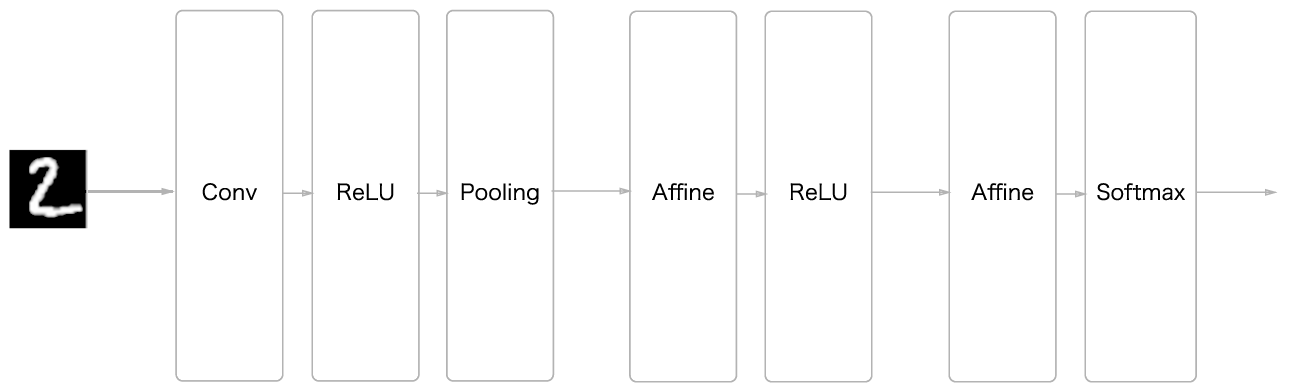

In [9]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-23.png")

이 그림의 CNN 네트워크는 "Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax"순으로 흐른다. 이를 `SimpleConvNet`이라는 이름의 클래스로 구현해보자.     

우선 `SimpleConvNet`의 초기화(`__init__`)를 살펴보자. 초기화 때는 다음 인수들을 받게 된다.

$\textbf{초기화 때 받는 인수}$      
- `input_dim` : 입력 데이터(채널 수, 높이, 너비)의 차원
- `conv_param` : 합성곱 계층의 하이퍼파라미터(딕셔너리). 딕셔너리의 키는 다음과 같다.
    - `filter_num` : 필터 갯수
    - `filter_size` : 필터 크기
    - `stride` : 스트라이드
    - `pad` : 패딩
- `hidden_size` : 은닉층(완전연결)의 뉴런 수
- `output_size` : 출력층(완전연결)의 뉴런 수
- `weight_init_std` : 초기화 때의 가중치 표준편차

여기에서 합성곱 계층의 하이퍼파라미터는 딕셔너리 형태로 주어지며(`conv_param`), 예를 들어 필요한 하이퍼파라미터의 값이 `{'filter_num' : 30, 'filter_size' : 5, 'pad' : 0, 'stride' : 1}`처럼 저장된다고 할 수 있다.

이제 `SimpleConvNet`의 초기화 코드를 살펴보자.

In [1]:
from collections import OrderedDict
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from common.functions import *

class SimpleConvNet:
    def __init__(self, input_dim = (1, 28, 28),
                 conv_param = {'filter_num':30, 'filter_size':5,
                               'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        """설명
        여기에서는 초기화 인수로 주어진 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼낸다(나중에 쓰기 쉽도록).
        그리고 합성곱 계층의 출력 크기를 계산한다.        
        """
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        
        """설명
        학습에 필요한 매개변수는 1번째 층의 합성곱 계층과 나머지 두 완전연결 계층의 가중치와 편향이다.
        이 매개변수들을 인스턴스 변수 params 딕셔너리에 저장한다. 1번째 츠의 합성곱 계층의 가중치를 W1, 편향을 b1이라는 키로 저장한다.
        마찬가지로 2번째 층의 완전연결 계층의 가중치와 편향을 W2와 b2로 저장하고, 마지막 3번째 층의 완전연결 계층의 가중치와 편향을 W3와 b3로 저장한다.
        """
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)  
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)                            
        
        
        """설명
        순서가 있는 딕셔너리(OrderedDict)인 layers에 계층들을 차례로 추가한다.
        마지막 SoftmaxwithLoss 계층만큼은 last_layer에 따로 저장한다.
        """
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                          conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()
        
    """설명
    이 코드에서 인수 x는 입력 데이터, t는 정답 레이블이다. 추론을 수행하는 predict 메서드는 초기화 때
    layers에 추가한 계층을 맨 앞에서부터 차례로 forward 메서드를 호출하며 그 결과를 다음 계층에 전달하게 된다. 손실 함수를 계산하는
    loss 메서드는 predict 메서드의 결과를 인수로 받아 마지막 계층인 SoftmaxWithLoss 계층의 forward 메서드를 호출한다.
    즉, 첫 계층부터 마지막 계층까지 forward를 처리한다.
    """    
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
        
        
    """설명
    매개변수의 기울기는 오차역전파법으로 계산한다. 이 과정은 순전파와 역전파를 반복한다. 
    지금까지 각 계층의 순전파와 역전파 기능을 제대로 구현했다면, 여기에서는 단지 그것들을 적절한 순서로 호출만 해주면 끝난다.
    마지막으로 grads 라는 딕셔너리 변수에 각 가중치 매개변수의 기울기를 저장하고 반환한다.
    """
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    
    

이상이 `SimpleConvNet`의 구현이다.      

이제 이 `SimpleConvNet`으로 MNIST 데이터셋을 학습해볼 차례이다. 학습을 위한 코드는 ch07/train_convnet.py에 있으니 참고하자.

train_convnet.py를 실행한 결과는 다음과 같다.

```python
=============== Final Test Accuracy ===============
test acc:0.9897
Saved Network Parameters!
```

#### [그림 7-24(0)] 훈련 및 시험 데이터 정확도

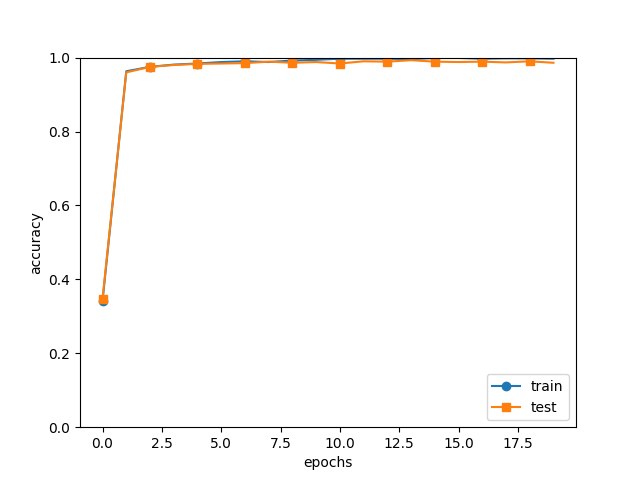

In [4]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-24(0).png")

결과에서 보다시피 SimpleConvNet을 MNIST 데이터셋으로 학습하면 훈련 데이터에 대한 정확도는 약 99.82%, 시험 데이터에 대한 정확도는 98.97%가 된다. 시험 데이터에 대한 정확도가 무려 99%라는 것은 비교적 작은 네트워크로서는 아주 높다고 할 수 있다. 다음 장에서는 계층을 더 깊게 하여 시험 데이터에 대한 정확도가 99%를 넘는 네트워크도 구현해볼 것이다.       

지금까지 살펴본 것처럼 합성곱 계층과 풀링 계층은 이미지 인식에 필수적인 모듈이라고 할 수 있다. 이미지라는 공간적인 형상에 담긴 특징을 CNN이 잘 파악하여 손글씨 숫자 인식에서 높은 정확도를 달성할 수 있었다.

## 7.6 CNN 시각화하기
CNN을 구성하는 합성곱 계층은 입력으로 받은 이미지 데이터에서 '무엇을 보고 있는'것일까? 이번 절에서는 합성곱 계층을 시각화해서 CNN이 보고 있는 것이 무엇인지 알아보도록 하자.

### 7.6.1 1번째 층의 가중치 시각화하기
조금 앞에서 MNIST 데이터셋으로 간단한 CNN 학습을 진행해보았는데, 그때 1번째 층의 합성곱 계층의 가중치는 그 형상이 $(30, 1, 5, 5)$였다(필터 30개, 채널 1개, $5 \times 5$크기). 필터의 크기가 $5 \times 5$이고 채널이 1개라는 것은 이 필터를 1채널의 회색조 이미지로 시각화할 수 있다는 뜻이다. 그럼 합성곱 계층(1층째) 필터를 이미지로 나타내보자. 여기에서는 학습 전과 후의 가중치를 비교하게되는데, 그 결과는 [그림7-24]처럼 된다(소스 코드는 ch07/visualize_filter.py에 있다).        

#### [그림7-24(1)] 학습 전의 1번째 층의 합성곱 계층의 가중치
가중치의 원소는 실수이지만, 이미지에서는 가장 작은 값(0)은 검은색, 가장 큰 값(255)은 흰색으로 정규화하여 표시함

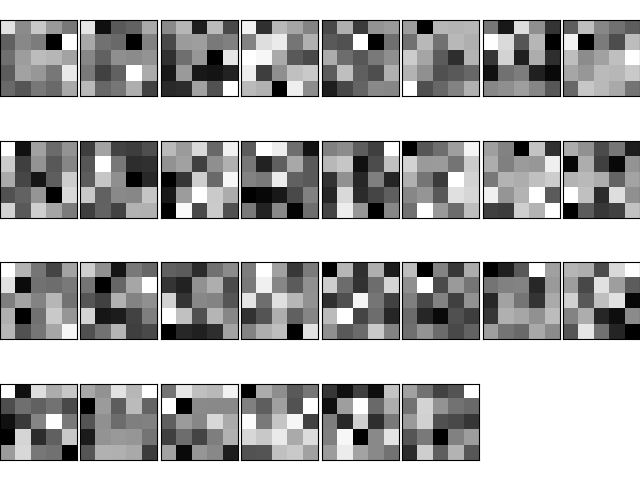

In [5]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-24(1).png")

#### [그림7-24(2)] 학습 후의 1번째 층의 합성곱 계층의 가중치
가중치의 원소는 실수이지만, 이미지에서는 가장 작은 값(0)은 검은색, 가장 큰 값(255)은 흰색으로 정규화하여 표시함

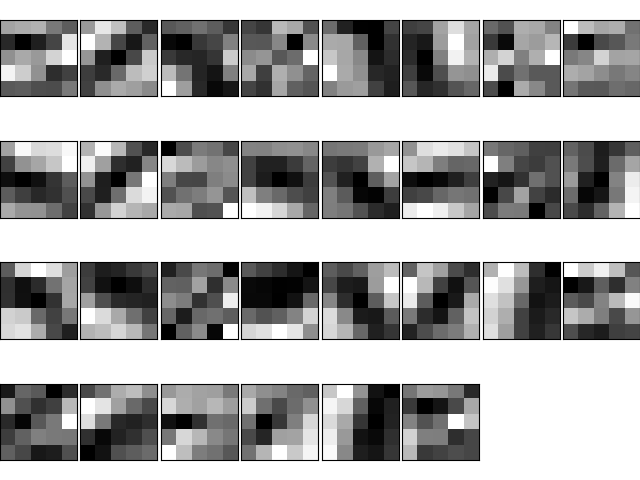

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-24(2).png")

[그림7-24]와 같이 학습 전 필터는 무작위로 초기화되고 있어 흑백의 정도에 규칙성이 없다. 한편, 학습을 마친 필터는 나름의 규칙성이 있는 이미지가 되었다. 흰색에서 검은색으로 점차 변화하는 필터와 덩어리($\small \text{블롭}^{\text{blob}}$)가 진 필터 등, 규칙을 띄는 필터로 바뀌었다.        

[그림7-24]의 오른쪽같이 규칙성 있는 필터는 '무엇을 보고 있는'걸까? 필터는 에지(색상이 바뀐 경계선)와 블롭(국소적으로 덩어리진 영역)등을 보고 있다. 가령 왼쪽 절반이 흰색이고 오른쪽 절반이 검은색인 필터는 [그림7-25]와 같이 세로 방향의 에지에 반응하는 필터이다.

#### [그림7-25] 가로 에지와 세로 에지에 반응하는 필터
출력 이미지 1은 세로 에지에 흰 픽셀이 나타나고, 출력 이미지 2는 가로 에지에 흰 픽셀이 많이 나온다.

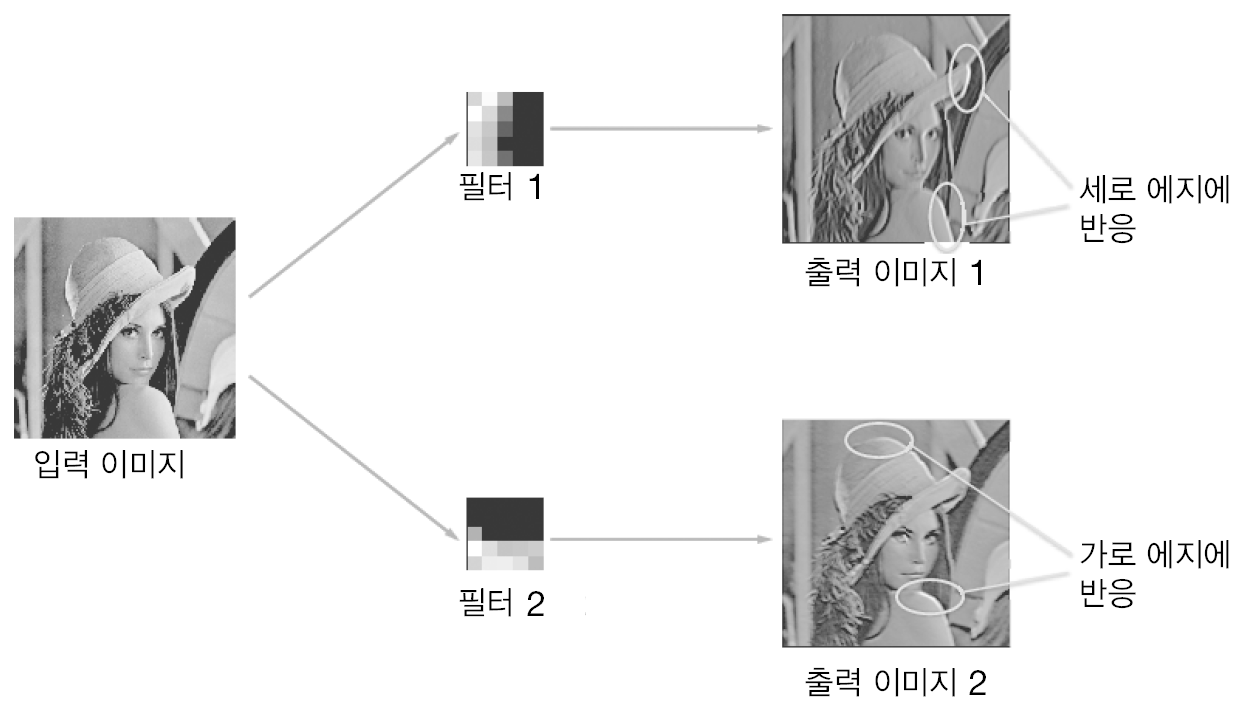

In [5]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-25.png")

[그림7-25]는 학습된 필터 2개를 선택하여 입력 이미지에 합성곱 처리를 한 결과로, '필터 1'은 세로 에지에 반응하며 '필터 2'는 가로 에지에 반응하는 것을 확인할 수 있다.     

이처럼 합성곱 계층의 필터는 에지나 블롭 등의 원시적인 정보를 추출할 수 있다. 이런 원시적인 저보가 뒷단 계층에 전달된다는 것이 앞에서 구현한 CNN에서 일어나는 일이다.

### 7.6.2 층 깊이에 따른 추출 정보 변화
앞 절의 결과는 1번째 층의 합성곱 계층을 대상으로 한 것이었다. 1번째 층의 합성곱 계층에서는 에지나 블롭 등의 저수준 정보가 추출된다 치자. 그럼 겹겹이 쌓인 CNN의 각 계층에서는 어떤 정보가 추출될까? 딥러닝 시각화에 관한 연구에 따르면, 계층이 깊어질수록 추출되는 정보(정확히는 강하게 반응하는 뉴런)는 더 추상화된다는 것을 알 수 있다.

[그림7-26]은 일반 사물 인식(자동차나 개 등)을 수행한 8층의 CNN이다. 이 네트워크 구조는 AlexNet이라 하는데, 합성곱 계층과 풀링 계층을 여러 겹 쌓고, 마지막으로 완전연결 계층을 거쳐 결과를 출력하는 구조이다. [그림7-26]에서 블록으로 나타낸 것은 중간 데이터이며, 그 중간 데이터에 합성곱 연산을 연속해서 적용하게 된다.

#### [그림7-26] CNN의 합성곱 계층에서 추출되는 정보
1번째 층은 에지와 블롭, 3번째 층은 텍스처, 5번째 층은 사물의 일부, 마지막 완전연결 계층은 사물의 클래스(개, 자동차)에 뉴런이 반응한다.

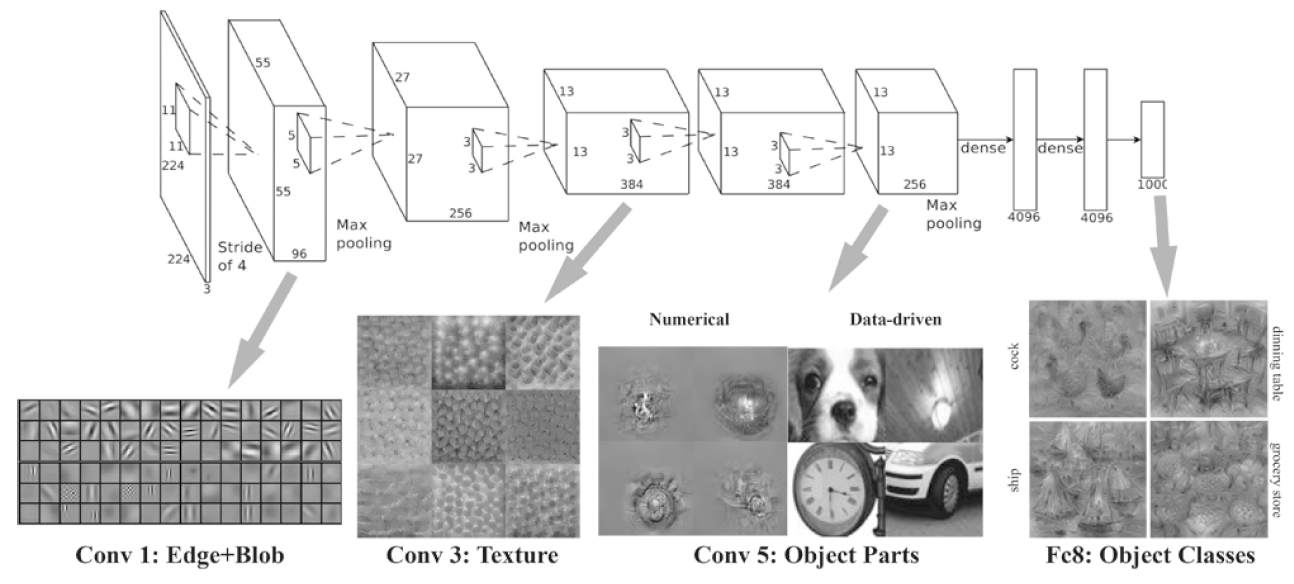

In [6]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-26.png")

딥러닝의 흥미로운 점은 [그림7-26]과 같이 합성곱 계층을 여러 겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 정보가 추출된다는 것이다. 처음 층은 단순한 에지에 반응하고, 이어서 텍스처에 반응하고, 더 복잡한 사물의 일부에 반응하도록 변화한다. 즉, 층이 깊어지면서 뉴런이 반응하ㅡㄴ 대상이 단순한 모양에서 '고급' 정보로 변화해가는 것이다. 다시 말하면 사물의 '의미'를 이해하도록 변화하는 것이다.

## 7.7 대표적인 CNN
지금까지 제안된 CNN 네트워크의 구성은 다양하다. 이번 절에서는 그중에서도 특히 중요한 네트워크를 두 개 소개할 것이다. 하나는 CNN의 원조인 LeNet이고, 다른 하나는 딥러닝이 주목받도록 이끈 AlexNet이다.       

### 7.7.1 LeNet
$\small \textbf{LeNet}$은 손글씨 숫자를 인식하는 네트워크로, 1998년에 제안되었다. [그림7-27]과 같이 합성곱 계층과 풀링 계층(정확히는 단순히 '원소를 줄이기'만 하는 서브샘플링 계층)을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력한다.        

#### [그림7-27] LeNet의 구성

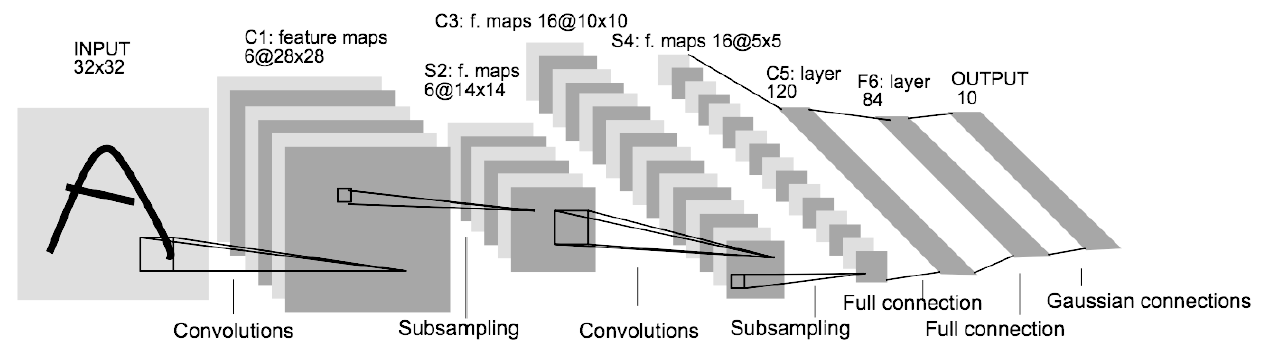

In [7]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-27.png")

LeNet과 '현재의 CNN'을 비교하면 몇 가지 면에서 차이가 있다. 첫 번째 차이는 활성화 함수이다. LeNet은 시그모이드 함수를 사용하는데 반해, 현재는 주로 ReLU를 사용하는 추세이다. 또, 원래의 LeNet은 서브샘플링을 통해 중간 데이터의 크기를 줄이지만 현재는 최대 풀링이 대세이다.        

이처럼 LeNet과 현재의 CNN은 어느정도 차이가 있지만 큰 차이는 아니다. LeNet이 지금부터 거의 20년 전에 제안된 '첫 CNN'이라는 점을 고려하면 이는 놀라운 사실이다.

### 7.7.2 AlexNet
LeNet과 비교해 훨씬 최근인 2012년에 발표된 $\small \textbf{AlexNet}$은 딥러닝 열풍을 일으키는 데 큰 역할을 하였다. [그림7-28]에서 보듯 그 구성은 기본적으로 LeNet과 크게 다르지 않다.

#### [그림7-28] AlexNet의 구성

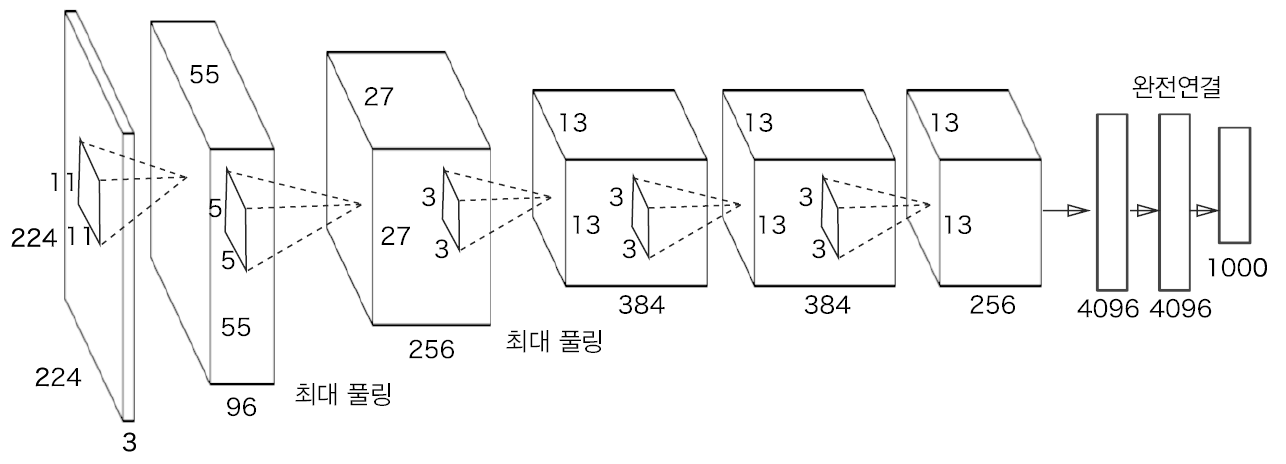

In [2]:
Image.open("C:\\Users\\SAMSUNG\\Downloads\\deep-learning-from-scratch-series\\Part-1\\chapter_7\\images\\fig 7-28.png")

AlexNet은 합성곱 계층과 풀링 계층을 거듭하며 마지막에 완전연결 계층을 거쳐 결과를 출력한다. LeNet에서 큰 구조는 바뀌지 않았지만, AlexNet에서는 다음과 같은 변화가 있었다.

- 활성화 함수로 ReLU를 사용한다.
- $\small \text{LRN}^{\text{Local Response Normalization}}$이라는 국소적 정규화를 실시하는 계층을 이용한다.
- 드롭아웃을 사용한다.

이상에서 보듯 네트워크 구성 면에서는 LeNet과 AlexNet에 큰 차이는 없다. 그러나 이를 둘러싼 환경과 컴퓨터 기술이 큰 진보를 이뤘다고 볼 수 있다. 대량의 데이터를 누구나 얻을 수 있게 되었고, 병렬 계산에 특화된 GPU가 보급되면서 대량의 연산을 고속으로 수행할 수 있게 되었다. 빅데이터와 GPU, 이것이 딥러닝 발전의 큰 원동력인 것이다.        

$\textbf{NOTE}$     
> 딥러닝(심층 학습)에는 대부분 수많은 매개변수가 쓰인다. 그래서 학습하려면 엄청난 양의 계산이 필요하며, 그 매개변수를 '적합'시키는 데에도 대량의 데이터가 필요하다. GPU와 빅데이터는 이러한 문제에 대한 해결책을 던져줬다고 할 수 있는 것이다.

## 7.8 정리
이번 장에서는 CNN에 대해 배웠다. CNN을 구성하는 기본 모듈인 '합성곱 계층'과 '풀링 계층'은 다소 복잡하지만, 한 번 이해하고 나면 이들을 어떻게 쓰느냐는 문제만 남게 된다. 이번 장에서는 합성곱 계층과 풀링 계층을 구현 수준으로 이해할 수 있도록 차근히 설명하였다. CNN은 이미지를 다루는 분야에서는 거의 예외 없이 쓰인다.       

$\textbf{이번 장에서 배운 내용}$
- CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
- 합성곱 계층과 풀링 계층은 `im2col`(이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할 수 있다.
- CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
- 대표적인 CNN에는 LeNet과 AlexNet이 있다.
- 딥러닝의 발전에는 빅데이터와 GPU가 크게 기여하였다.